In [232]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## IMPORTS

In [233]:
from copy import deepcopy, copy
from hdbscan import all_points_membership_vectors, HDBSCAN
from matplotlib.axes import Axes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple, Optional
from umap import UMAP
from upsetplot import from_memberships, plot, UpSet, from_indicators
import colorcet as cc
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy


from project_modules.clustering import make_feature_importance_df, make_topN_features, make_plot_df

from project_modules.clustering import plot_feature_importances, plot_clusters, plot_multiple_features

# colour palette work
palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')

# make a matplotlib cmap from limegreen to white
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("limegreen-white", 
                                         ["white", "limegreen"])



FONTSIZE = 24

In [234]:
# parameters and dicts

# heatmap parameters
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}
# from the data dictionary
site_fullname_dict = {
                  'LDN': "London",
                  'MTL': "Montreal",
                  'SAN': "San Diego",
                  'RIO': "Rio de Janeiro",
                  'LUS': "Lusaka",
}
# from the data dictionary
site_fullname_int_dict = {
                  1: "London",
                  2: "Montreal",
                  3: "San Diego",
                  4: "Rio de Janeiro",
                  5: "Lusaka",
}

# assign consistent styles
site_style_dict = {
              1: 'o',
              2: 'D',
              3: 'P',
              4: 'X',
              5: 's',
}

In [235]:
# input and output paths

figdir    = "./OUTPUT/lc-pos-figures"
reportdir = "../lc2-report"
data_dir  = "../lc-project-data"

## FUNCTIONS

In [236]:
# TODO: move these to a module


In [237]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [238]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    # if keep_features == True:
    #     pass
    # else:
    #     df2 = df2.set_index(list(new_df.columns))

    return df2

In [239]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    # figsize = (6,64),
                    ax = None,
                    cmap = cc.cm.bjy,
                    top_n = None,
                    ):
#===============================================================================

    # TODO: colour map to match the cluster thumbnails
    # TODO: drop age, sex

    norm = None

    # qq.astype(int)
    if ax == None:
        fig, ax = plt.subplots()
    else:
        ax = ax


    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if top_n is not None:
        mm = mm[:top_n]

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        # cmap = cc.cm.bjy
        # fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # # qq.astype(int)
        # fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    # cmap = cc.bjy, 
                    cmap = cmap,
                    ax = ax, 
                    cbar = False, 
                    vmin = 0, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

## LOAD DATA

In [240]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

today = "2024-05-05"

# load the dataset from disk
ds_all = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
ds     = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')

In [241]:
df_all = ds_all.data.to_pandas()
df     = ds.data.to_pandas()

In [242]:
# drop __index_level_0__
df = df.drop(columns = ["__index_level_0__"])

In [243]:
# import good feature names
feature_map_df = pd.read_csv(f"./JSON/niceFeatures.csv")

# construct a dict with feature as key and clean as value
feature_map = {row["feature"]: row["clean"] for i, row in feature_map_df.iterrows()}

# load the colourmap dict
import json

with open("./JSON/selectFeaturePalette_NiceFeat.json", "r") as f:
    feature_colour_map = json.load(f)

print(f"{len(feature_map)} features loaded.")
print(f"{len(feature_colour_map)} colours loaded.")

94 features loaded.
81 colours loaded.


In [244]:
feature_map

{'CD-adjunctive___1': 'CoV Vasopressor/Inotrope',
 'CD-difficulty_with_concentrat___4': 'LC+ Concentration Unknown Origin',
 'CD-hospitalized': 'CoV Hospitalized',
 'CD-medication_received___1': 'CoV Steroids',
 'CD-medication_received___2': 'CoV Remdesivir',
 'CD-medication_received___3': 'CoV Anticoagulant',
 'CD-medication_received___4': 'CoV Colchicine',
 'CD-medication_received___5': 'CoV Antibiotics',
 'CD-medication_received___6': 'CoV Other Meds',
 'CD-memory_problems___4': 'LC+ Memory Unknown Origin',
 'CD-required_oxygen': 'CoV Oxygen',
 'CD-respiratory-other-4': 'LC+ Respiratory Unknown Origin',
 'CD-severity_level___0': 'CoV UnInfected',
 'CD-severity_level___1': 'CoV Mild',
 'CD-severity_level___2': 'CoV Moderate',
 'CD-severity_level___3': 'CoV Severe',
 'CD-spo2': 'CoV SpO2',
 'CD-type_of_care___1': 'CoV ICU',
 'CD-type_of_care___2': 'CoV Non-ICU',
 'CD-anxiety___1': 'CoV Anxiety',
 'CD-anxiety___2': 'LC+ Anxiety',
 'CD-insomnia___1': 'CoV Insomnia',
 'CD-insomnia___2': 

In [245]:
cc.glasbey_hv[68:99]

[[0.654902, 0.215686, 0.682353],
 [0.772549, 0.858824, 0.882353],
 [0.301961, 0.431373, 1.0],
 [0.607843, 0.576471, 0.003922],
 [0.803922, 0.345098, 0.419608],
 [0.937255, 0.870588, 0.996078],
 [0.47451, 0.352941, 0.0],
 [0.372549, 0.533333, 0.603922],
 [0.705882, 1.0, 0.572549],
 [0.368627, 0.447059, 0.419608],
 [0.321569, 0.0, 0.4],
 [0.019608, 0.529412, 0.317647],
 [0.517647, 0.12549, 0.435294],
 [0.235294, 0.588235, 0.019608],
 [0.396078, 0.45098, 0.0],
 [0.945098, 0.627451, 0.423529],
 [0.372549, 0.313725, 0.270588],
 [0.741176, 0.0, 0.290196],
 [0.815686, 0.407843, 0.152941],
 [0.843137, 0.588235, 0.670588],
 [0.537255, 0.364706, 1.0],
 [0.509804, 0.423529, 0.462745],
 [0.168627, 0.333333, 0.72549],
 [0.431373, 0.486275, 0.733333],
 [0.905882, 0.835294, 0.827451],
 [0.364706, 0.0, 0.094118],
 [0.486275, 0.231373, 0.003922],
 [0.501961, 0.694118, 0.490196],
 [0.784314, 0.85098, 0.490196],
 [0.0, 0.909804, 0.231373],
 [0.486275, 0.698039, 1.0]]

## LC+, LC-, HC

### Select which sets of features to use

In [246]:
LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
LC_neg = df.query('LC_STATUS == "LC_NEG"').copy() # type: ignore 
HC     = df.query('LC_STATUS == "HC"').copy()     # type: ignore

In [247]:
LC_pos.shape, LC_neg.shape, HC.shape

((2194, 448), (3367, 448), (103, 448))

In [248]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass
LC_pos

sex   age  SITE  MED-Analgesics  MED-Anesthetics  MED-Antibacterials  \
0     2.0  30.0     2               0                0                   0   
1     1.0  33.0     2               0                0                   0   
2     2.0  36.0     2               0                0                   0   
3     2.0  50.0     2               0                0                   0   
4     1.0  40.0     2               0                0                   0   
...   ...   ...   ...             ...              ...                 ...   
5659  1.0  48.0     3               0                0                   0   
5660  2.0  42.0     3               0                0                   0   
5661  1.0  23.0     3               0                0                   0   
5662  1.0  71.0     3               0                0                   0   
5663  2.0  58.0     3               0                0                   0   

      MED-Anticonvulsants  MED-Antidepressants  MED-Antifungals  \
0                       0                    0                0   
1                       0                    0                0   
2                       0                    0                0   
3                       0                    0                0   
4                       0                    0                0   
...                   ...                  ...              ...   
5659                    0                    0                0   
5660                    0                    0                0   
5661                    0                    0                0   
5662                    0                    0                0   
5663                    0                    0                0   

      MED-Antimigraine-agents  ...  LABS-IND-troponinihigh  \
0                           0  ...                     0.0   
1                           0  ...                     0.0   
2                           0  ...                     0.0   
3                           0  ...                     0.0   
4                           0  ...                     0.0   
...                       ...  ...                     ...   
5659                        0  ...                     0.0   
5660                        0  ...                     0.0   
5661                        0  ...                     0.0   
5662                        0  ...                     0.0   
5663                        0  ...                     0.0   

      LABS-IND-troponint  LABS-IND-troponinthigh  LABS-IND-urea  LABS-IND-wbc  \
0                    0.0                     0.0            0.0           0.0   
1                    0.0                     0.0            0.0           0.0   
2                    0.0                     0.0            0.0           0.0   
3                    0.0                     0.0            0.0           0.0   
4                    0.0                     0.0            0.0           0.0   
...                  ...                     ...            ...           ...   
5659                 0.0                     0.0            1.0           0.0   
5660                 0.0                     0.0            1.0           1.0   
5661                 0.0                     0.0            0.0           0.0   
5662                 0.0                     0.0            1.0           0.0   
5663                 0.0                     0.0            1.0           1.0   

      SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5  
0         0.0      0.0      0.0      0.0      0.0  
1         0.0      0.0      0.0      0.0      0.0  
2         0.0      0.0      0.0      0.0      0.0  
3         1.0      0.0      0.0      0.0      0.0  
4         0.0      0.0      0.0      0.0      0.0  
...       ...      ...      ...      ...      ...  
5659      0.0      0.0      1.0      0.0      0.0  
5660      0.0      0.0      0.0      0.0      0.0  
5661      0.0      0.0      1.0      1.0      0.0  
5662      0.0      0.0    

In [249]:
# make a list of the columns
ftrs = list(df.columns)

# how many features start with one of ["SYMP", "CD", "MED"]?

for sw in ["SYMP", "CD", "MED", "VAX", "HHX", "IMG","LAB", "SUBS"]:
    print(sw, len([f for f in ftrs if f.startswith(sw)]))

SYMP 56
CD 244
MED 28
VAX 1
HHX 54
IMG 9
LAB 47
SUBS 5


# CLUSTERING

In [250]:
# clustering

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [251]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = df["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = df["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = df["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = df["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


print(LC_pos_.shape)
# for c in LC_pos_.columns:
#     print(c)
# sort the feature names alphabetically
LC_pos_ = LC_pos_.sort_index(axis = 1)
print(LC_pos_.shape)

(2194, 246)
(2194, 246)


In [252]:
# get a list of all features that start with CD- and end with ___1
# these are the initial covid symptoms
new_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___1")]

new_symptoms = []

# get a list of all features that start with CD- and end with ___2
# these are the follow-up covid symptoms
worse_symptoms = [f for f in LC_pos_.columns if f.startswith("CD-") and f.endswith("___2")]

lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

new_and_worse = new_symptoms + worse_symptoms + lc_symptoms
new_and_worse = lc_symptoms

In [253]:
# sort new_and_worse
new_and_worse = sorted(new_and_worse)
new_and_worse

['SYMPT-abdominal_pain___2',
 'SYMPT-chest_pain___2',
 'SYMPT-confusion_altered_mental_s___2',
 'SYMPT-cough___2',
 'SYMPT-diarrhea___2',
 'SYMPT-dizziness___2',
 'SYMPT-ear_pain___2',
 'SYMPT-extremity_weakness_or_numb___2',
 'SYMPT-fatigue___2',
 'SYMPT-fever_38_0oc___2',
 'SYMPT-headache___2',
 'SYMPT-hemoptysis_bloody_sputum___2',
 'SYMPT-joint_pain_arthralgia___2',
 'SYMPT-leg_swelling_edema___2',
 'SYMPT-loss_of_appetite___2',
 'SYMPT-loss_of_taste_lost_of_smel___2',
 'SYMPT-muscle_aches_myalgia___2',
 'SYMPT-nausea_vomiting___2',
 'SYMPT-night_sweats___2',
 'SYMPT-red_eye_conjunctivitis___2',
 'SYMPT-runny_nose_rhinorrhea___2',
 'SYMPT-seizure___2',
 'SYMPT-shortness_of_breath_dyspne___2',
 'SYMPT-skin_rash___2',
 'SYMPT-sore_throat___2',
 'SYMPT-trouble_speaking_aphasia_d___2',
 'SYMPT-weight_loss___2',
 'SYMPT-wheezing_or_stridor___2']

In [254]:
# drop SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_.drop(columns=['SITE']))     # type: ignore


# sort X randomly
# X = X.sample(frac = 1)

## Use UMAP to visualize the data and cluster

### Handling missing values

In [255]:
# the clustering algorithms depend on the data being complete
# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 0)

print(X.shape)

(2189, 245)


In [257]:
sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

### EMBED and CLUSTER

In [258]:
# pipeline for scaling, embedding, and clustering 

# min cluster size scales as sqrt(n)
min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples': min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
                'metric': 'hamming',
            }

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', UMAP(**umap_parms, verbose = True)),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# # TODO: move this to a function
# points   = pipe["embed"].embedding_
# clusters = pipe["cluster"].labels_
# probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
#                            axis = 1)

# clusters = cluster_labels


# plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
# plot_df["Cluster"]            = [c+1 for c in clusters]
# plot_df["Cluster Confidence"] = probs
# plot_df["Site"]               = sites

plot_df, cluster_labels = make_plot_df(pipe, 
                                        sites,
                                        site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100


UMAP(metric='hamming', random_state=42, verbose=True)
Tue May 28 17:06:53 2024 Construct fuzzy simplicial set
Tue May 28 17:06:56 2024 Finding Nearest Neighbors
Tue May 28 17:06:56 2024 Finished Nearest Neighbor Search
Tue May 28 17:06:56 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue May 28 17:07:00 2024 Finished embedding


In [259]:
plot_df

x          y  Cluster  Cluster Confidence Site
0     26.170727  17.893805        3            0.000000  MTL
1     23.713652  20.257908        5            0.912636  MTL
2     24.506067  18.773035        7            0.000000  MTL
3     22.991543  18.760071        7            1.000000  MTL
4     26.674486  19.691662        3            0.000000  MTL
...         ...        ...      ...                 ...  ...
5659  25.658329  19.783495        3            1.000000  SAN
5660  24.603148  17.977221        6            0.000000  SAN
5661  26.321119  19.673117        3            0.000000  SAN
5662  27.331882  19.464495        3            0.000000  SAN
5663  23.146049  23.268045        5            0.000000  SAN

[2189 rows x 5 columns]

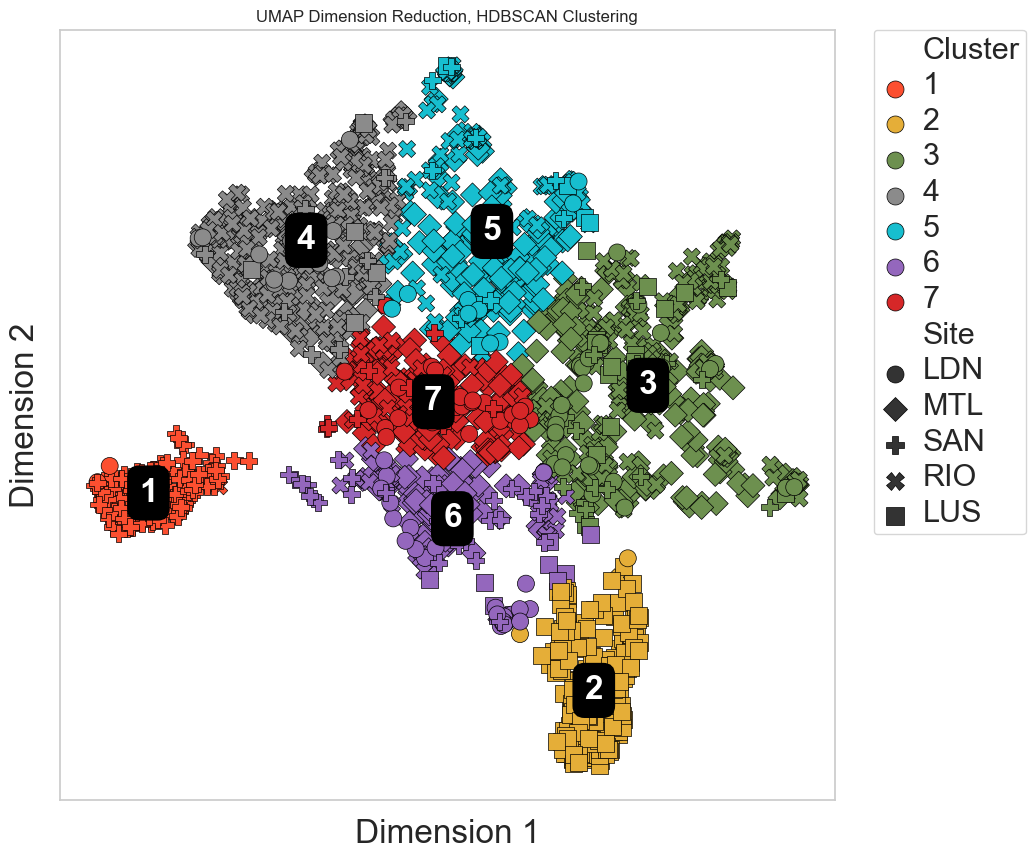

In [260]:
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title        = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids    = True, 
              size_by_prob = False, 
              ax           = None,
              centroid_kws = {"alpha": 1.0, "palette_dict":None, "show_edge": False},)

# # plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

In [261]:
# 2024-05-06
# redundant: recoded the erroneous records (21 MTL patients) to patient_type 99 to remove from the LC_pos and LC_neg datasets

# # find the indices of the points that x < 4
# idx = plot_df.query("x < 4").index
# idx

# # # read the records from "LC_POSITIVE_RECORD_IDS.csv"

# record_ids = pd.read_csv(f"{data_dir}/LC_POSITIVE_RECORD_IDS.csv", header = 0, index_col = 0)

# # # record_ids

# # # get the patient record_id that corresponds to idx
# record_ids.loc[idx]["record_id"].to_list()
# # # sns.heatmap(X.loc[idx].filter(regex = 'SYMPT').T, **heatmap_parms
# # # sns.heatmap(X.sample(20).filter(regex = 'SYMPT').T, **heatmap_parms)

#### Cluster by Site

In [262]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site.copy()

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# sort the index by the order in site_name_dict
cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

print(cluster_by_site)

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    2.0   27.0   13.0    9.0   34.0   23.0
MTL        0.0    0.0  277.0   90.0  213.0  135.0  180.0
SAN      190.0    1.0   16.0   11.0    8.0   29.0   11.0
RIO        1.0    1.0  175.0  335.0   71.0   38.0   29.0
LUS        0.0  229.0   18.0    5.0    6.0   10.0    0.0


In [263]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

cbs.to_latex(f"{reportdir}/basic-cluster-by-site.tex")

In [264]:
c1 = plot_df.groupby("Cluster")["Site"].value_counts(normalize = True).unstack().T.fillna(0)#.astype(int)
c1 = c1.loc[site_name_dict.values()]
c1

Cluster         1         2         3         4         5         6         7
Site                                                                         
LDN      0.010363  0.008584  0.052632  0.028634  0.029316  0.138211  0.094650
MTL      0.000000  0.000000  0.539961  0.198238  0.693811  0.548780  0.740741
SAN      0.984456  0.004292  0.031189  0.024229  0.026059  0.117886  0.045267
RIO      0.005181  0.004292  0.341131  0.737885  0.231270  0.154472  0.119342
LUS      0.000000  0.982833  0.035088  0.011013  0.019544  0.040650  0.000000

#### RFC Model to identify features that differentiate clusters

In [265]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )



# instantiate the Boruta feature selector
from boruta_py.boruta import BorutaPy

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100


BorutaPy finished running.

Iteration: 	47 / 100
Confirmed: 	33
Tentative: 	0
Rejected:

BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=117,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x301ADD040),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x301ADD040,
         verbose=1)

In [266]:
# make a subset of the data with the important features and 
# fit a classifiera on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)

RandomForestClassifier(max_depth=7, n_estimators=117, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x301ADD040)

In [267]:
fi_df1 = make_feature_importance_df(clf, important_features)
features20 = make_topN_features(fi_df1, 20, feature_map, feature_colour_map)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


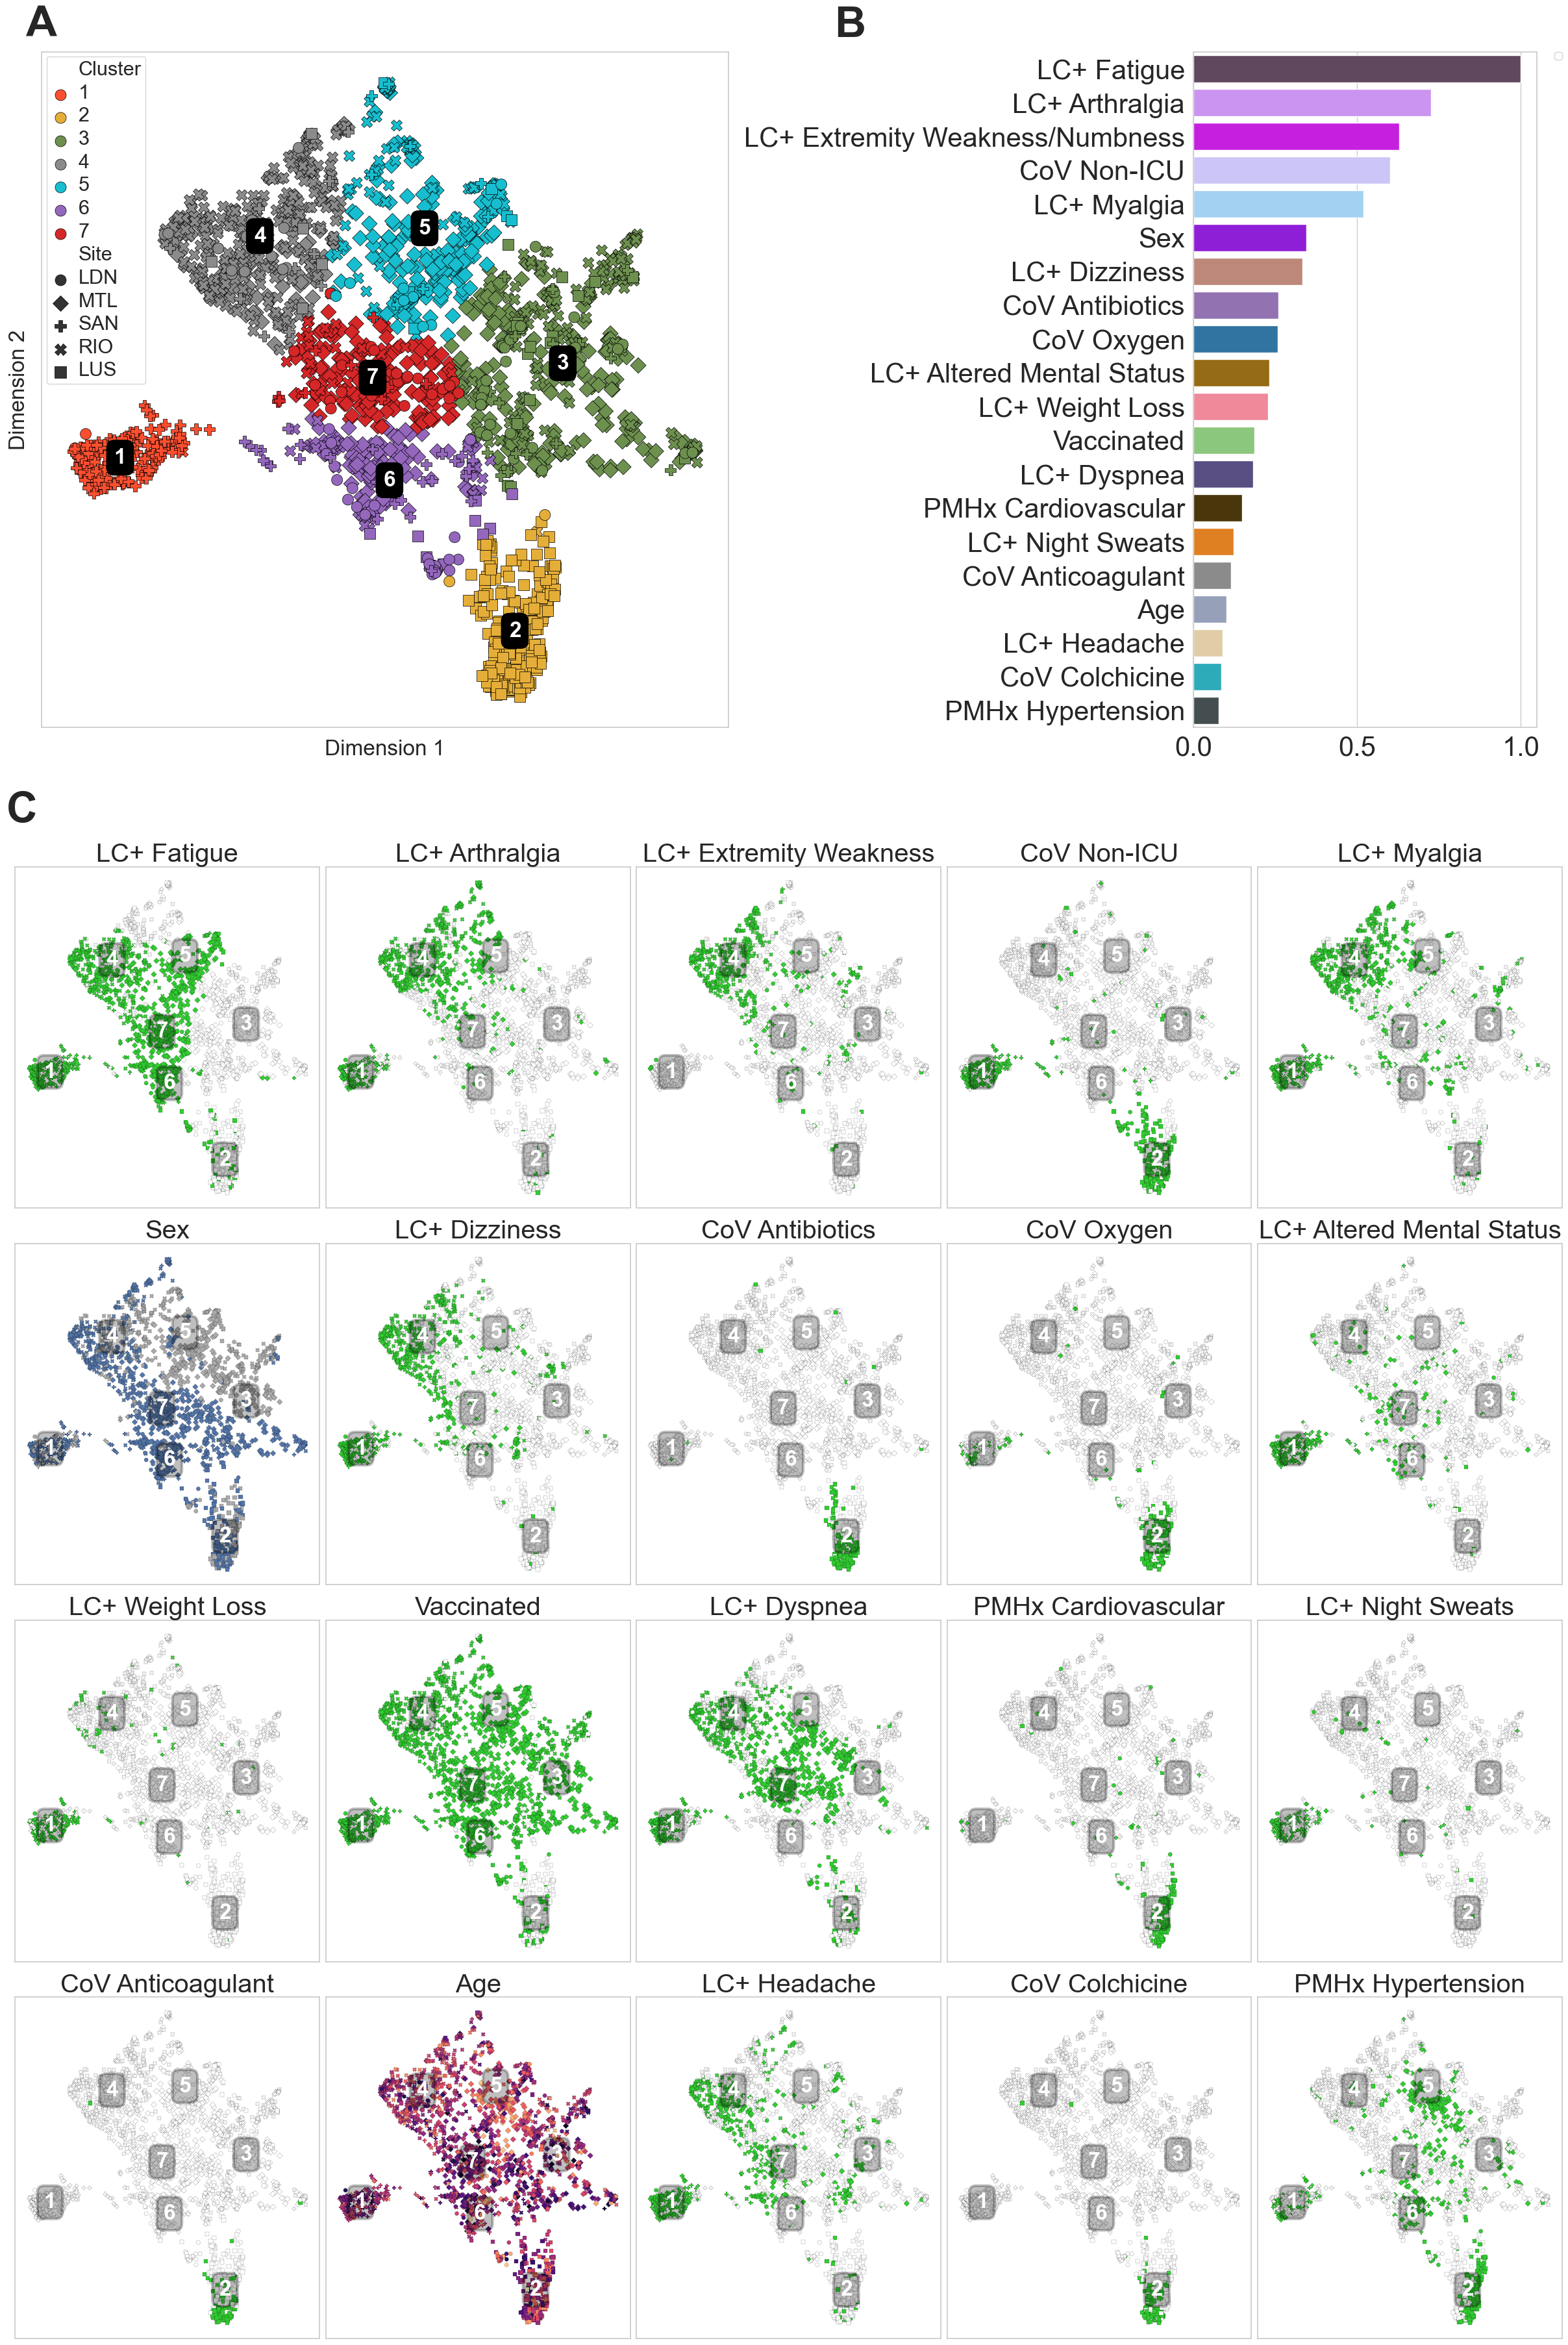

In [268]:
fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[2,4], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, site_name_dict, palette_dict, title = None, centroids = True, size_by_prob = False, ax = axs0[0])
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )

plot_feature_importances(features20, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
axs1 = subfigs[1].subplots(4,5)

plot_multiple_features(fi_df1, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        fontsize = FONTSIZE*1.2,
                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

if SAVE:
    plt.savefig(f"{figdir}/feature-importances-600.png", dpi = 600, bbox_inches = 'tight')
    plt.savefig(f"{figdir}/feature-importances-300.png", dpi = 300, bbox_inches = 'tight')
    plt.savefig(f"{figdir}/feature-importances-300.jpg", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

### Excursion Plots

In [269]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, 
                     index = clf.feature_names_in_, 
                     columns = ["Importance"])

# fi_df = make_feature_importance_df(clf, important_features)

# make a table of all of the features and their rankings
fff = pd.DataFrame({
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
fff["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in fff.iterrows():
    if f["Importance"] == True:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
fff.sort_values(by = "FI", ascending = False, inplace = True)

In [270]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[fff["Feature"]]

# augment with cluster labels
A["cluster"] = [c+1 for c in cluster_labels]
M["cluster"] = [c+1 for c in cluster_labels]


In [271]:
cluster_by_site

Cluster      1      2      3      4      5      6      7
Site                                                    
LDN        2.0    2.0   27.0   13.0    9.0   34.0   23.0
MTL        0.0    0.0  277.0   90.0  213.0  135.0  180.0
SAN      190.0    1.0   16.0   11.0    8.0   29.0   11.0
RIO        1.0    1.0  175.0  335.0   71.0   38.0   29.0
LUS        0.0  229.0   18.0    5.0    6.0   10.0    0.0

In [272]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
# round to 1 decimal place
cbsm = cbsm.round(1)

cbsm

cluster            1     2     3     4     5     6     7
Site                                                    
London           1.8   1.8  24.5  11.8   8.2  30.9  20.9
Montreal         0.0   0.0  30.9  10.1  23.8  15.1  20.1
San Diego       71.4   0.4   6.0   4.1   3.0  10.9   4.1
Rio de Janeiro   0.2   0.2  26.9  51.5  10.9   5.8   4.5
Lusaka           0.0  85.4   6.7   1.9   2.2   3.7   0.0

In [273]:
zzz = M.groupby("cluster").mean()

# get the first 20 columns
zzz = zzz[fff["Feature"][:20]]

# rename the columns
for c in zzz.columns:
    zzz.rename(columns = {c: feature_map[c]}, inplace = True)

# drop age and sex
zzz = zzz.drop(columns = ["Age", "Sex"])

In [274]:
zzz

LC+ Fatigue  LC+ Arthralgia  LC+ Extremity Weakness/Numbness  \
cluster                                                                 
1           0.994819        0.751295                         0.020725   
2           0.171674        0.042918                         0.021459   
3           0.009747        0.021442                         0.070175   
4           0.770925        0.819383                         0.746696   
5           0.732899        0.400651                         0.110749   
6           0.768293        0.036585                         0.056911   
7           0.880658        0.189300                         0.102881   

         CoV Non-ICU  LC+ Myalgia  LC+ Dizziness  CoV Antibiotics  CoV Oxygen  \
cluster                                                                         
1           0.927461     0.860104       0.844560         0.015544    0.243523   
2           0.785408     0.055794       0.038627         0.630901    0.660944   
3           0.017544     0.085770       0.083821         0.005848    0.009747   
4           0.019824     0.832599       0.698238         0.004405    0.008811   
5           0.019544     0.185668       0.104235         0.003257    0.000000   
6           0.182927     0.178862       0.231707         0.012195    0.044715   
7           0.037037     0.119342       0.209877         0.000000    0.000000   

         LC+ Altered Mental Status  LC+ Weight Loss  Vaccinated  LC+ Dyspnea  \
cluster                                                                        
1                         0.906736         0.761658    0.953368     0.740933   
2                         0.038627         0.008584    0.236052     0.227468   
3                         0.025341         0.009747    0.941520     0.282651   
4                         0.057269         0.092511    0.936123     0.616740   
5                         0.055375         0.026059    0.964169     0.436482   
6                         0.146341         0.028455    0.959350     0.134146   
7                         0.164609         0.008230    0.983539     0.814815   

         PMHx Cardiovascular  LC+ Night Sweats  CoV Anticoagulant  \
cluster                                                             
1                   0.031088          0.621762           0.000000   
2                   0.523605          0.025751           0.484979   
3                   0.013645          0.003899           0.001949   
4                   0.008811          0.022026           0.002203   
5                   0.006515          0.006515           0.000000   
6                   0.052846          0.028455           0.000000   
7                   0.008230          0.020576           0.000000   

         LC+ Headache  CoV Colchicine  PMHx Hypertension  
cluster                                                   
1            0.865285        0.000000           0.305699  
2            0.081545        0.437768           0.540773  
3            0.124756        0.000000           0.134503  
4            0.464758        0.004405           0.044053  
5            0.123779        0.000000           0.351792  
6            0.195122        0.008130           0.247967  
7            0.292181        0.000000           0.148148

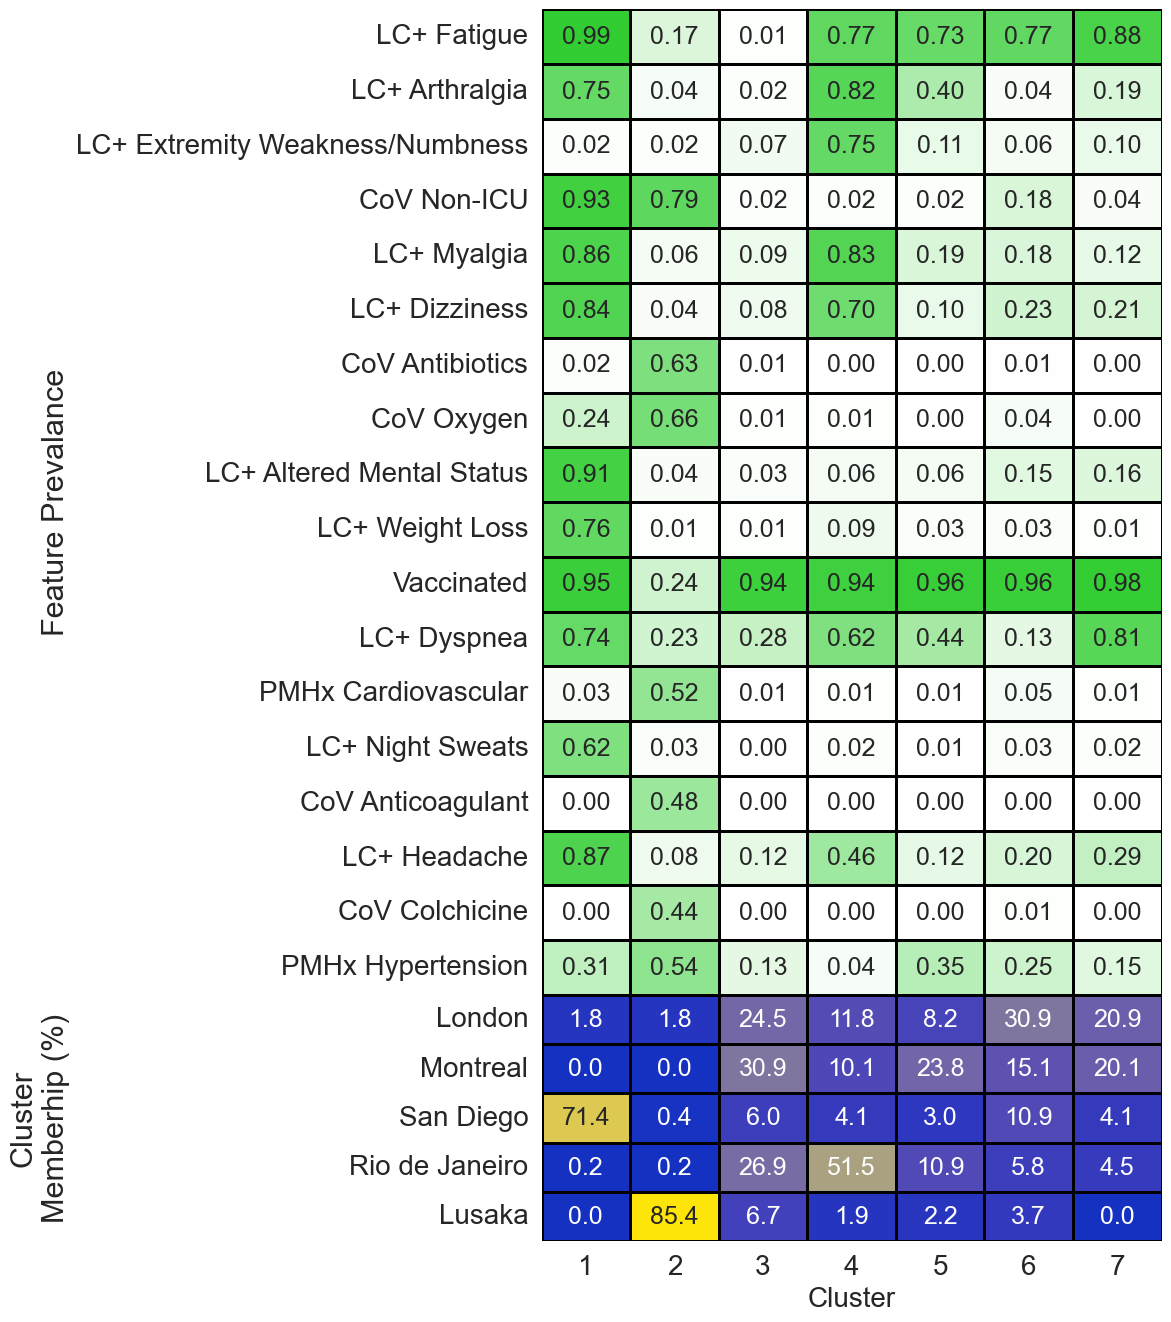

In [275]:


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(8,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

sns.heatmap(zzz.T, 
            cmap = cmap, 
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
plt.savefig(f"{figdir}/feature-prevalence-by-cluster-600.png", dpi = 600, bbox_inches = 'tight')
plt.savefig(f"{figdir}/feature-prevalence-by-cluster-300.png", dpi = 300, bbox_inches = 'tight')


### UPSET PLOTS

In [276]:
# A["SITE"] = LC_pos_["SITE"]
# II = pd.DataFrame(scaler.inverse_transform(A.drop(["cluster", "SITE"], axis = 1))) # type: ignore

# # get column names and index names from X 
# II.columns = X.columns
# II.index   = X.index


# # A.shape, X.shape, II.shape
# # vv = A.drop("cluster", axis = 1)
# B = II.copy()

# # augment with site labels
# B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# interesting = list(fff["Feature"][:5])
# upset_A = make_upset_data(A, 
#                        interesting, 
#                        )

# upset_data = make_upset_data(B, 
#                                 interesting, 
#                                 keep_features = True
#                                 )

# indicators_bool = upset_data.select_dtypes(include = ['bool'])
# us = UpSet(
#     from_indicators(indicators_bool, data = upset_data),
#     min_subset_size=15,
#     # max_subset_size=200,
#     show_counts                = True,
#     sort_categories_by         = "-input",
#     subset_size                = "count",
#     intersection_plot_elements = 0,
#     orientation                = "horizontal",
# )

# # us.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = cc.glasbey_light[0],  linewidth = 3, )

# us.add_stacked_bars(by="SITE", 
#                        title="Count SITE", 
#                        elements=10, 
#                        colors = cc.m_glasbey_hv, 
#                        )

# us.plot()
# plt.show()

In [277]:
# upset = UpSet(upset_A, 
#                 subset_size = "count", 
#                 orientation = "horizontal", 
#                 sort_categories_by         = "-input",
#                 show_counts = False, 
#                 intersection_plot_elements = 0,
#                 max_subset_size = 200
#                 )
# # upset.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = "red", linewidth = 3)
# # upset.style_categories(">HHX-HIV or AIDS", shading_facecolor = "blue")

# # upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)


# upset.plot()
# plt.show()

In [278]:
# from scipy.stats import chi2_contingency

# rd = {}

# for site1 in site_name_dict.values():

#     for site2 in site_name_dict.values():

#         for col in X.columns:

#             # get the index of rows where SITE is site1 or site2
#             idx = LC_pos_["SITE"].isin([site1, site2])

#             print(idx)

#             ct = pd.crosstab(LC_pos_.loc[idx]["SITE"], X.loc[idx][col]).rename(index = site_name_dict)


#             print(ct)

#             result = chi2_contingency(ct)
#             if result[1] < 0.05:
#                 # print(ct)
#                 print(f"{site}: \t{col} --> p = {result[1]}")
#                 rd.update({site: result[1]})


# # for col in X.columns:


# #     ct = pd.crosstab(LC_pos_["SITE"], X[col]).rename(index = site_name_dict)

# #     result = chi2_contingency(ct)
# #     if result[1] < 0.05:
# #         # print(ct)
# #         # print(f"{col}: p = {result[1]}")
# #         rd.update({col: result[1]})

# # # make dataframe from rd
# # rd_df = pd.DataFrame.from_dict(rd, orient = "index", columns = ["p-value"])

# # # sort by p-value
# # rd_df.sort_values(by = "p-value", inplace = True, ascending = False)
# # rd_df

# By SITE for subphenotypes at each site

In [362]:
# select the columns to use
LC_COLUMNS = LC_pos_.columns

# remove SITE from LC_COLUMNS
LC_COLUMNS = LC_COLUMNS.drop(["SITE", "age"])

In [363]:
# cluster pipeline, iterating over the sites

result_dict = {}

for i, (k,v) in enumerate(site_name_dict.items()):
    # print(i, k, v)

    print(f"Site {k}: {v}")

    # LC_pos_ = df.query(f"SITE == {k}").copy()
    the_data = LC_pos_.query(f"SITE == {k}").copy()

    # drop age
    the_data = the_data.drop(columns = ["age"])


    X = scaler.fit_transform(the_data)     # type: ignore
    X = X.dropna(axis = 0)
    X = X[LC_COLUMNS]

    print(f"Data shape = {the_data.shape}")
    print(f"X shape    = {X.shape}")


    # reduce and cluster
    # sklearn pipelines
    min_cluster_size = int(np.sqrt(X.shape[0]))

    hdb_parms = {
                    # min_cluster_size is roughly 
                    # sqrt(n) where n is the number of samples
                    'min_cluster_size': min_cluster_size, 
                    'min_samples': min_cluster_size,
                    'cluster_selection_method': 'leaf', # more granular
                    'cluster_selection_epsilon': 0.1,
                }

    umap_parms = {
                    'n_components': 2,
                    'spread':       1.0,
                    'random_state': 42,
                    # 'metric':      'euclidean',
                    # 'metric':      'hamming',
                    'verbose':      False
                }

    # turn off userwarnings from umap
    import warnings
    warnings.filterwarnings("ignore")
    
    # instantiate the pipeline
    pipe = Pipeline([
                    ('scaler', MinMaxScaler()),
                    ('embed', UMAP(**umap_parms)),
                    ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                    ])

    # apply to the feature dataframe
    pipe.fit(X)

    # get the plot dataframe and cluster labels
    sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
    plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)

    # what fraction of the data is in each cluster?
    # print(plot_df["Cluster"].value_counts(normalize = True)*100)

    # use all cores
    clf = RandomForestClassifier(n_jobs=-1, 
                                #  n_estimators = 100, 
                                #  class_weight='balanced', 
                                max_depth=7
                                )

    # instantiate the Boruta feature selector
    from boruta_py.boruta import BorutaPy

    boruta = BorutaPy(clf, 
                    #   n_estimators = 1_000, 
                    n_estimators = 'auto',
                    verbose      = 0, 
                    random_state = 42, 
                    perc         = 100
                    )
    boruta.fit(X, cluster_labels)

    # make a subset of the data with the important features and 
    # fit a classifiera on it, using the cluster labels as the target
    important_features = X.columns[boruta.support_]
    clf.fit(X[important_features], cluster_labels)

    # print(important_features, clf.feature_importances_)

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()

    # # sosrt columns in the order set in fff
    M = M[important_features]

    # # augment with cluster labels
    M["cluster"] = [c+1 for c in cluster_labels]

    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()



    case_dict = {'plot_df': plot_df, 
                 'important_features': important_features,
                 'mfv': mfv,
                 'classifier': clf, 
                 'boruta': boruta, 
                 'X': X,
                 'cluster_labels': cluster_labels,
                 }

    result_dict.update({v: case_dict})

# plt.show()

Site 1: LDN
Data shape = (110, 245)
X shape    = (110, 244)
Site 2: MTL
Data shape = (895, 245)
X shape    = (895, 244)
Site 3: SAN
Data shape = (266, 245)
X shape    = (266, 244)
Site 4: RIO
Data shape = (651, 245)
X shape    = (650, 244)
Site 5: LUS
Data shape = (272, 245)
X shape    = (272, 244)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


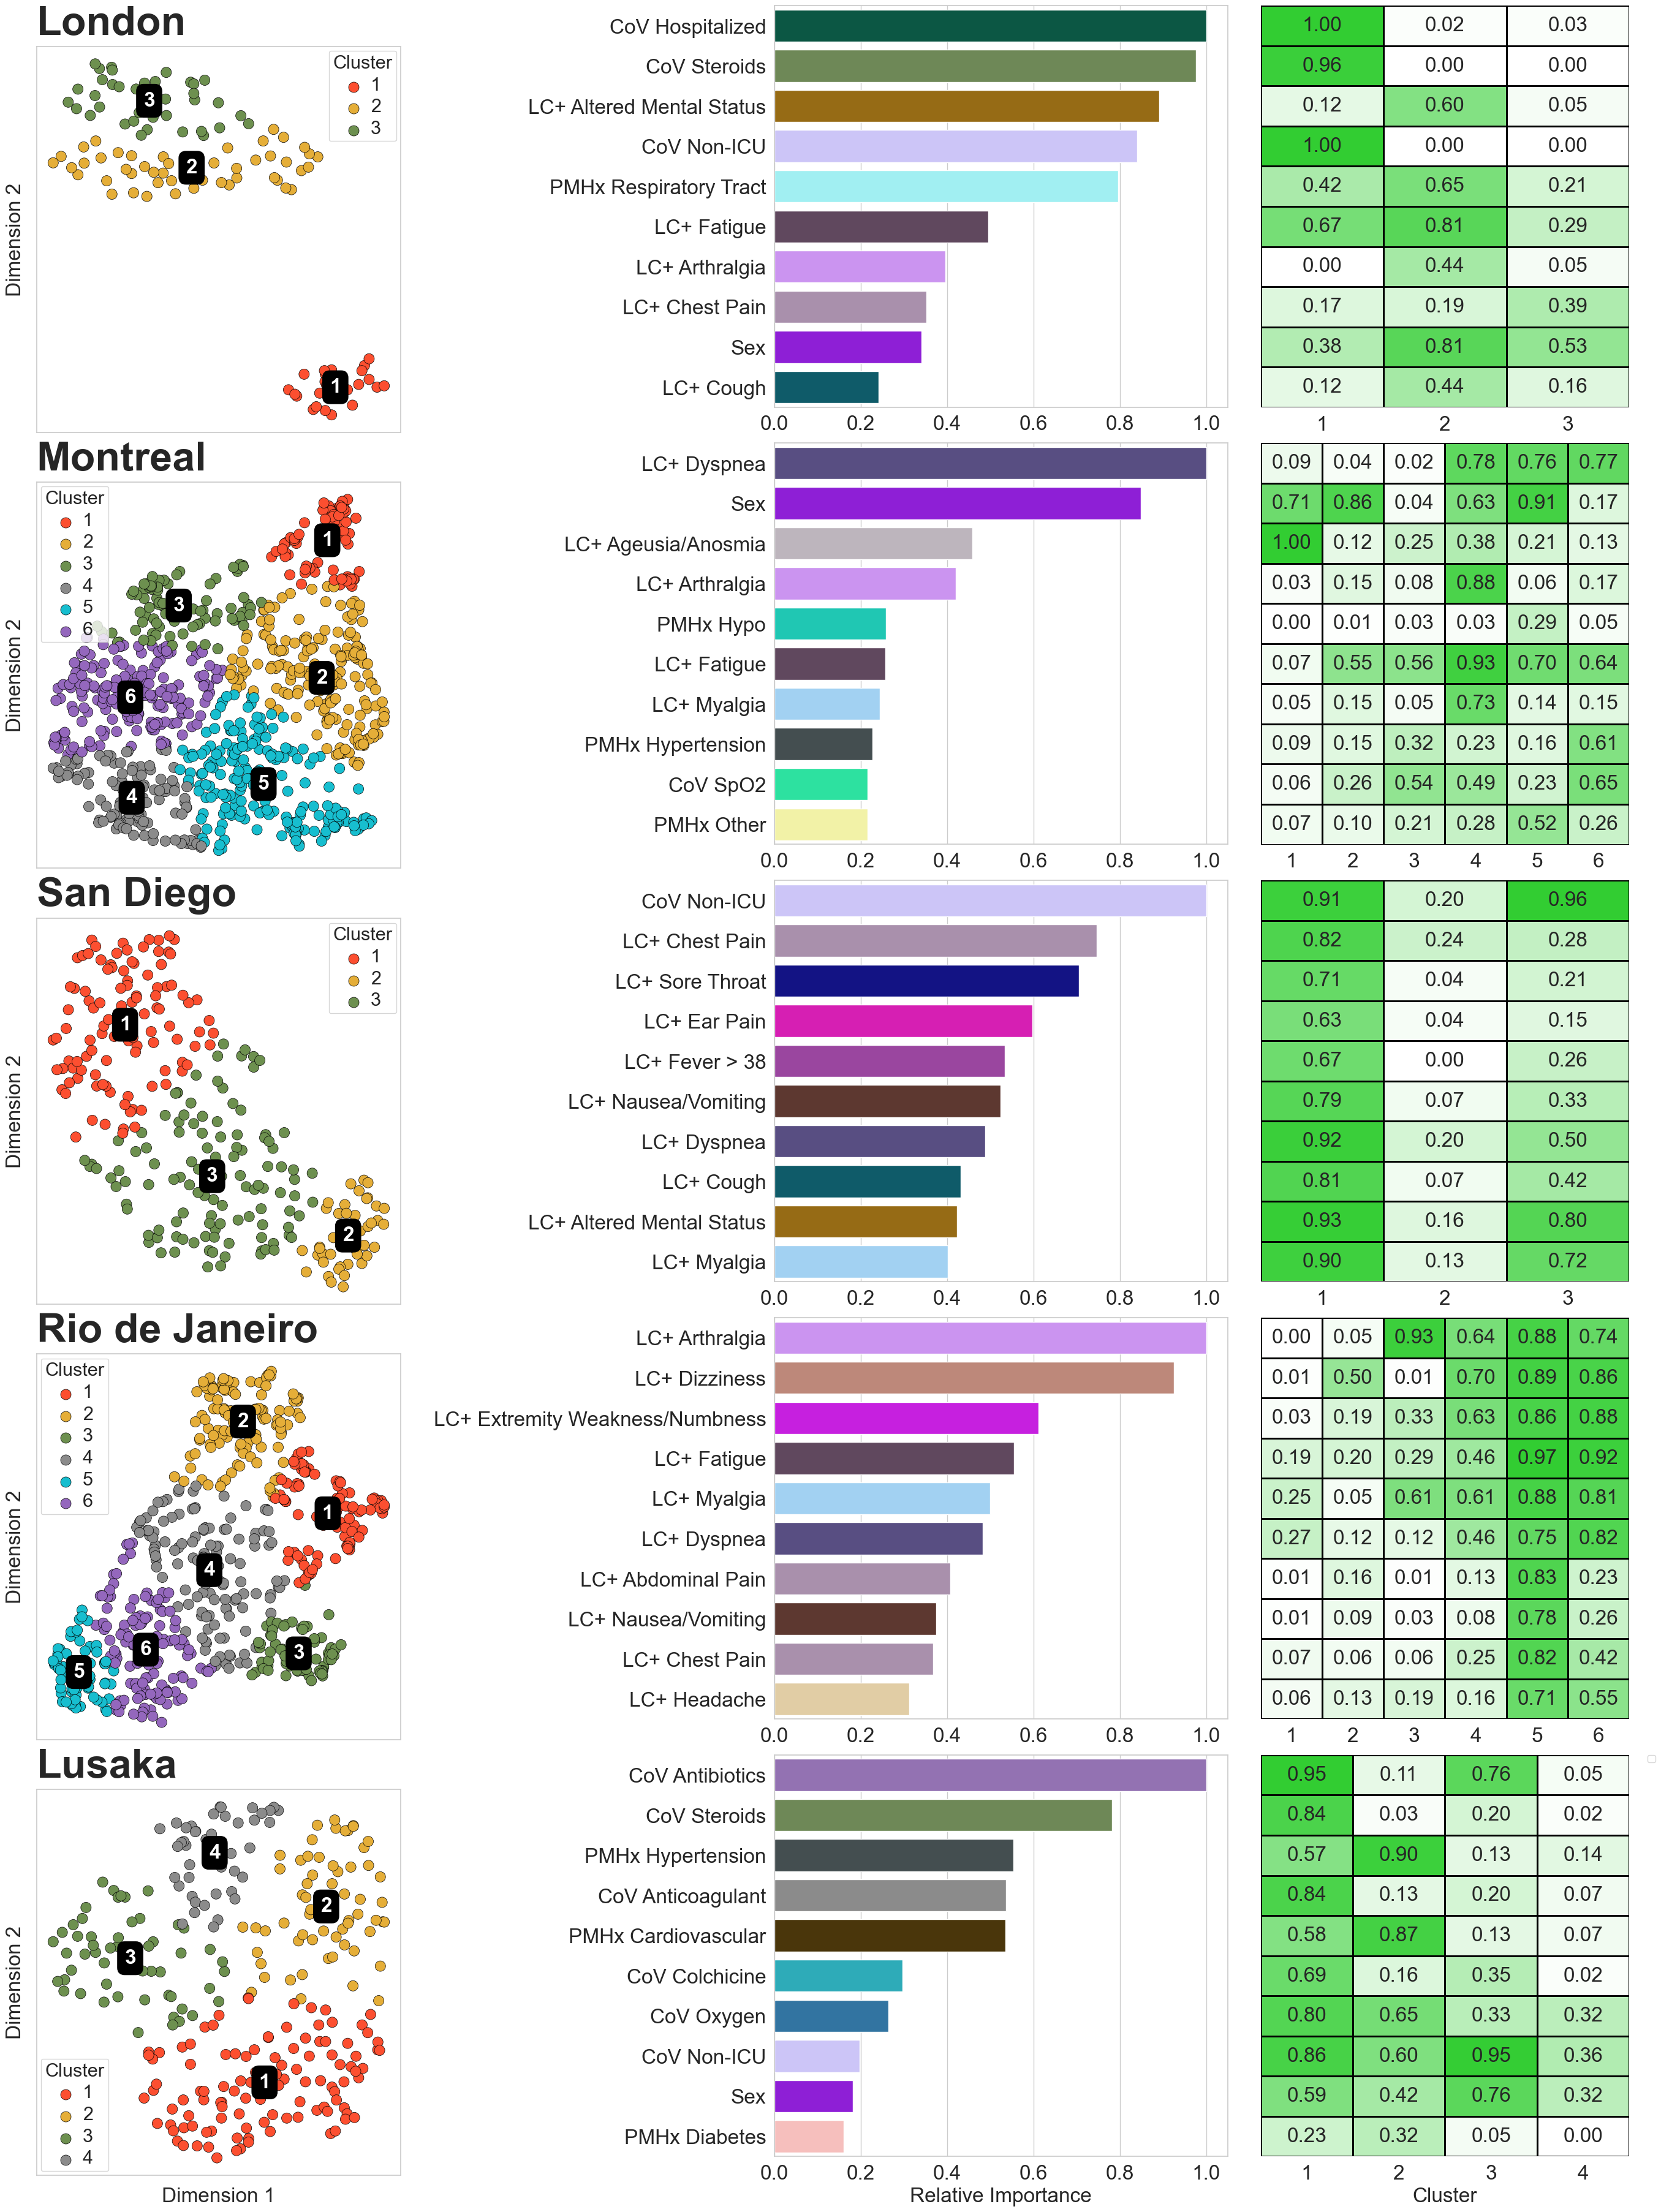

In [364]:
# make the figure

fig     = plt.figure(layout="constrained", figsize=(27,36), )
subfigs = fig.subfigures(1,3, wspace=0.05, hspace = 0.1, width_ratios=[1,2,1])

axl = subfigs[0].subplots(5, 1)
axc = subfigs[1].subplots(5, 1, sharex = False)
axr = subfigs[2].subplots(5, 1, sharex = False)

for i,item in enumerate(result_dict.items()):

    k, v = item

    plot_df            = v['plot_df']
    important_features = v['important_features']
    X                  = v['X']

    # clusters
    plot_clusters(plot_df, 
                  site_name_dict, 
                  palette_dict,
                  title        = None, 
                  centroids    = True, 
                  size_by_prob = False, 
                  ax           = axl[i], 
                  style        = None
                  )
    # turn off the x label
    axl[i].set_xlabel("", fontsize = FONTSIZE)

    # feature importances
    fi_df = make_feature_importance_df(v['classifier'], v['important_features'])
    # select only the top10 features
    features10 = make_topN_features(fi_df, 
                                    10, 
                                    feature_map, 
                                    feature_colour_map)

    plot_feature_importances(features10, 
                             feature_map, 
                             feature_colour_map, 
                             axc[i], 
                             FONTSIZE)

    # the mean feature values
    mfv = X[important_features].mean()

    # # make a heatmap 0f the mean value per feature per cluster
    M = X.copy()
    M = M[important_features]
    # # augment with cluster labels
    M["cluster"] = [c+1 for c in v['cluster_labels']]
    # # get the mean value of each feature per cluster
    mfv = M.groupby("cluster").mean()


    # sort the mfv columns by the order of the important features
    mfv = mfv[features10["OLD Feature"]]

    # print(features10["Feature"], features10["OLD Feature"])

    # print(mfv)

    # map the feature names to the new names
    mfv.columns = features10["Feature"]

    # heatmaps
    sns.heatmap(mfv.T,
                cmap = cmap, 
                # ax = ax, 
                cbar = False, 
                vmin = 0, 
                linewidth = 1, 
                # linewidth = 0.5, 
                square = False, 
                linecolor = 'k',
                annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 24},
                ax = axr[i]
    )

    # turn off the y axis label
    axr[i].set_ylabel("", fontsize = FONTSIZE)

    # turn off y ticks
    axr[i].set_yticks([])

    #make tick labels larger
    axr[i].tick_params(axis='both', which='major', labelsize=FONTSIZE)
    axr[i].set_xlabel("", fontsize = FONTSIZE)


    axl[i].annotate(f"{site_fullname_dict[k]}",
                        xy=(0.0, 1.01), 
                        xycoords='axes fraction',
                        xytext=(0.0,0.0), 
                        textcoords = 'offset points',
                        fontsize = FONTSIZE*2,
                        horizontalalignment='left', 
                        verticalalignment='bottom',
                        fontweight = "bold",
                        )



axl[4].set_xlabel("Dimension 1", fontsize = FONTSIZE)
axr[4].set_xlabel("Cluster", fontsize = FONTSIZE)
axc[4].set_xlabel("Relative Importance", fontsize = FONTSIZE)

plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site-300.png", dpi = 300, bbox_inches = 'tight')
plt.savefig(f"{figdir}/subphenotype-feature-importances-by-site-600.png", dpi = 600, bbox_inches = 'tight')


# By SYMPTOM Status
- new, worsening, etc

In [553]:
lc_symptoms = [f for f in LC_pos_.columns if f.startswith("SYMPT-") and f.endswith("___2")]

In [554]:
# select only the features in new_and_worse
X = LC_pos_[lc_symptoms].copy()
print(X.shape)

# drop rows with missing values
X.dropna(inplace = True, axis = 0)
print(X.shape)

# drop rows with all zeros
# X = X.loc[(X != 0).any(axis = 1)]
print(X.shape)

(2194, 28)
(2194, 28)
(2194, 28)


In [555]:
# drop certain features

# drop features that contain adjunctive
X = X.drop(columns = X.filter(regex = 'adjunctive').columns)

# drop features that contain "medication_received"
X = X.drop(columns = X.filter(regex = 'medication_received').columns)

# drop features that contain "type_of_care"
X = X.drop(columns = X.filter(regex = 'type_of_care').columns)

# drop features that contain "ventilatory_support_type"
X = X.drop(columns = X.filter(regex = 'ventilatory_support_type').columns)

print(X.shape)

(2194, 28)


In [556]:
# cluster pipeline

min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'min_samples':      min_cluster_size,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
                'min_dist':     0.25,
                # 'metric': 'cosine',
                # 'metric': 'hamming',
            }

# define the transformer
umap_transformer = UMAP(**umap_parms, verbose = True)
embedding_model = umap_transformer

# instantiate the pipeline
pipe = Pipeline([
                ('scaler', MinMaxScaler()),
                ('embed', embedding_model),
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

# get the dataframe and the labels
sites = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)
plot_df, cluster_labels = make_plot_df(pipe, sites, site_name_dict)



UMAP(min_dist=0.25, random_state=42, verbose=True)
Tue May 28 19:53:21 2024 Construct fuzzy simplicial set
Tue May 28 19:53:22 2024 Finding Nearest Neighbors
Tue May 28 19:53:22 2024 Finished Nearest Neighbor Search
Tue May 28 19:53:22 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue May 28 19:53:28 2024 Finished embedding


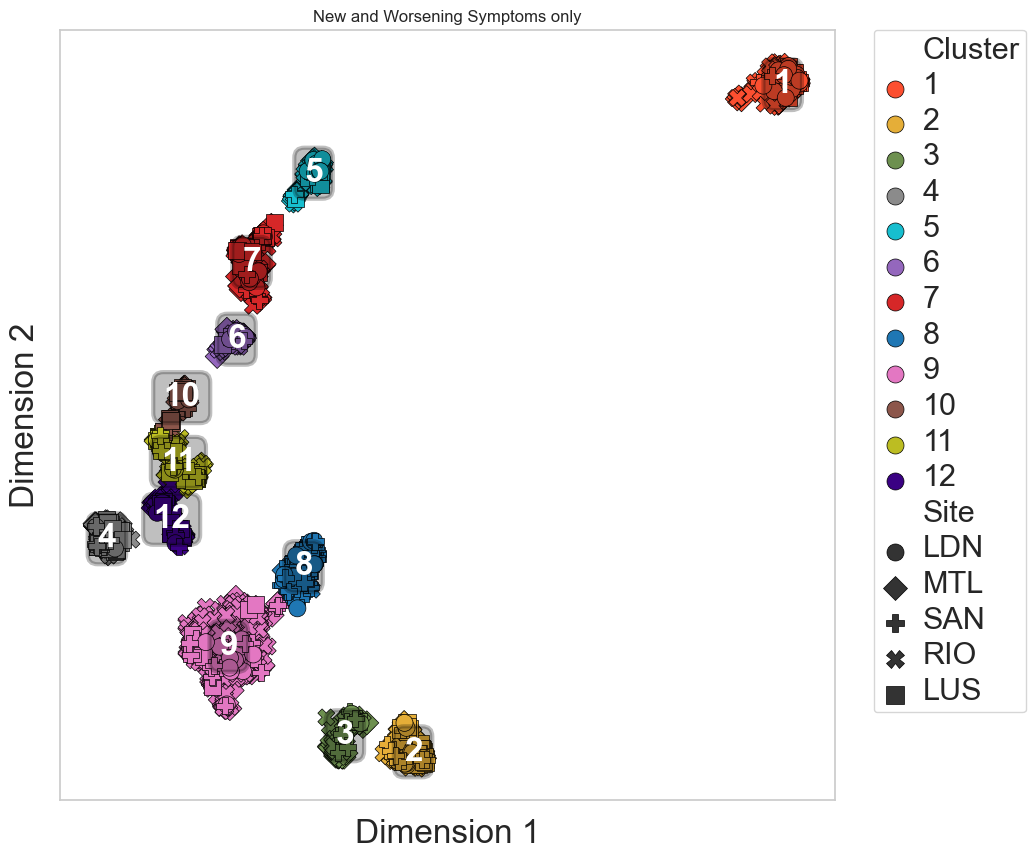

In [557]:
# plot the clusters
plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = f"New and Worsening Symptoms only", 
              centroids = True, 
              size_by_prob = False, 
              ax = None,
              centroid_kws = {"alpha": 0.25, "palette_dict":None, "show_edge": False},)


In [558]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts(normalize = False).unstack().T.fillna(0)#.astype(int)

cbs = cluster_by_site

# divid by the row sum
cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

# show only 2 decimal places
# cluster_by_site = cluster_by_site

# output cluster_by_site to latex
# cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")
# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

In [559]:
# sort by order in site_name_dict
cbs = cbs.loc[site_name_dict.values()]

# rename index values using site_fullname_dict
cbs.index = cbs.index.map(site_fullname_dict)
cbs = cbs.astype(int)

cbs.to_latex(f"{reportdir}/SYMPT_2-cluster-by-site.tex")

In [560]:
cbsm = cluster_by_site.T/cluster_by_site.sum(axis = 1)*100

# rename the index column
cbsm.index.name = "cluster"

# map the site_fullname_dict to the index
cbsm.columns = cbsm.columns.map(site_fullname_dict)
cbsm = cbsm.T
# round to 1 decimal place
cbsm = cbsm.round(1)

# sort by the order in site_name_dict
cbsm = cbsm.loc[site_fullname_dict.values()]

cbsm

cluster           1     2    3     4    5    6     7     8     9     10    11  \
Site                                                                            
London          19.1  11.8  3.6   1.8  9.1  3.6  20.9   8.2  10.9   3.6   4.5   
Montreal        17.2  14.2  8.2   3.4  8.3  9.5   9.1   0.2  17.9   3.7   3.5   
San Diego        2.6   4.1  3.4   3.0  0.8  0.4   3.4  69.9   7.1   1.5   2.6   
Rio de Janeiro   4.1   3.2  2.3  11.4  3.8  2.0   4.1   0.2  52.8   1.4   9.7   
Lusaka           4.0  11.8  1.5  24.6  8.8  1.5   9.6   0.0   2.6  18.4  11.8   

cluster          12  
Site                 
London          2.7  
Montreal        5.0  
San Diego       1.1  
Rio de Janeiro  4.9  
Lusaka          5.5

In [561]:
# find important features

# classifier
clf2 = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )

# boruta
boruta = BorutaPy(clf2, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )

# fit, with the cluster_labels as targets
boruta.fit(X, cluster_labels)

# get the important features
important_features = X.columns[boruta.support_]

# now fit the classifier on these features
clf2.fit(X[important_features], cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100


BorutaPy finished running.

Iteration: 	27 / 100
Confirmed: 	22
Tentative: 	0
Rejected: 	6


RandomForestClassifier(max_depth=7, n_estimators=96, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x31F9C7B40)

In [562]:
# dataframes with the feature importance and topN features
fi_df = make_feature_importance_df(clf2, important_features)
top_features = make_topN_features(fi_df, 20, feature_map, feature_colour_map)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


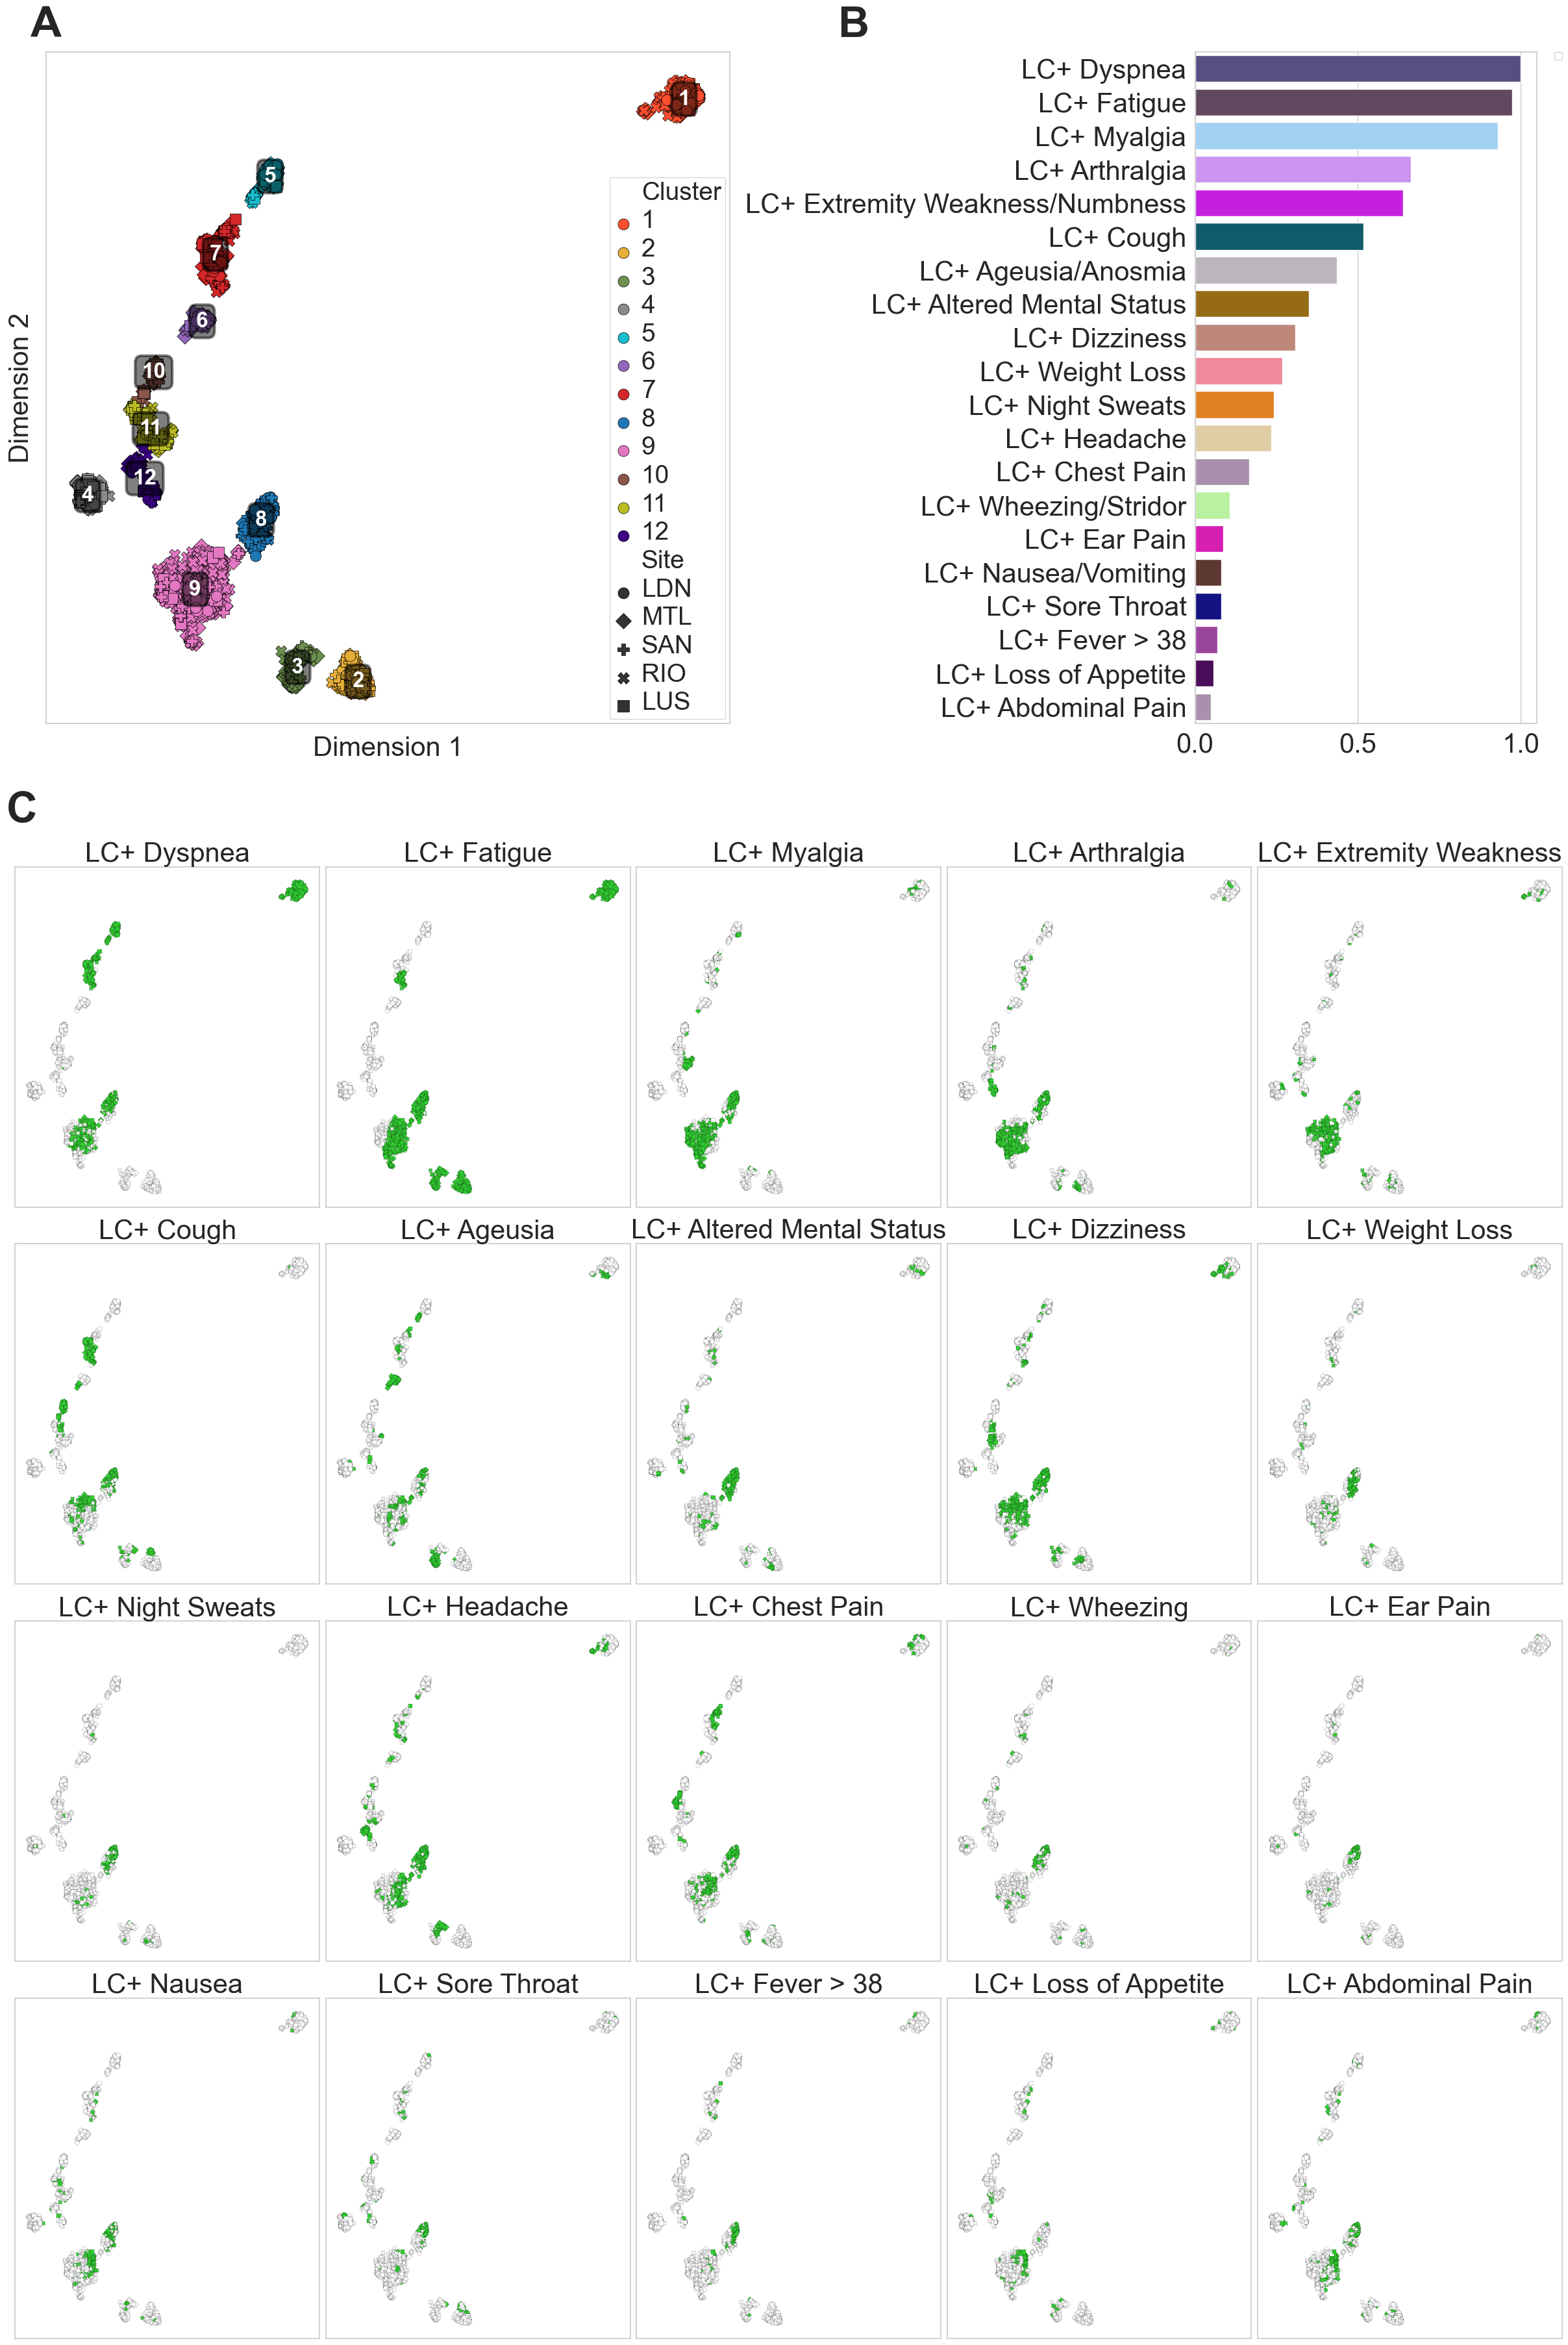

In [564]:
# plot

# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)
n_rows = int(np.ceil(n/5))

# h_factor = 

fig     = plt.figure(layout="constrained", figsize=(24,36))
subfigs = fig.subfigures(2, 1, wspace=0.05, height_ratios=[1,2], hspace = 0.05)

axs0 = subfigs[0].subplots(1, 2, width_ratios=[2,1])
# subfigs[0].set_facecolor('lightblue')

plot_clusters(plot_df, 
              site_name_dict, 
              palette_dict, 
              title = None, 
              centroids = True, 
              size_by_prob = False, 
              ax = axs0[0],
              FONTSIZE = FONTSIZE*1.25,
              centroid_kws = {"alpha": 0.5, "palette_dict":None, "show_edge": False},)
# add annotation abve the plot
axs0[0].annotate("A",
                    xy=(0.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


plot_feature_importances(top_features, 
                         feature_map, 
                         feature_colour_map, 
                         axs0[1], 
                         FONTSIZE*1.25)


axs0[1].annotate("B",
                    xy=(-1.0, 1.01), 
                    xycoords='axes fraction',
                    xytext=(0.0,0.0), 
                    textcoords = 'offset points',
                    fontsize = FONTSIZE*2,
                    horizontalalignment='center', 
                    verticalalignment='bottom',
                    fontweight = "bold",
                    )


# make an array of axes for the second subfigure
# get the number of top_features
n = len(top_features)

axs1 = subfigs[1].subplots(n_rows,5)

plot_multiple_features(fi_df, 
                        X,
                        plot_df, 
                        feature_map, 
                        site_name_dict,
                        site_style_dict,
                        highlight_colour = "limegreen",
                        ax = axs1,
                        subfig_label = " ",
                        show_centroids = False,
                        fontsize = FONTSIZE*1.25,

                        )

# subfigs[1].suptitle(" ")
subfigs[1].suptitle('C', fontsize=FONTSIZE*2, fontweight='bold', x = 0.0, y = 1.02, ha='left', va='top')
# plt.show()

SAVE = True

if SAVE:
    plt.savefig(f"{figdir}/SYMPT_2-only-feature-importances-300.png", dpi = 300, bbox_inches = 'tight')
    plt.savefig(f"{figdir}/SYMPT_2-only-feature-importances-600.png", dpi = 600, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/SYMPT_2-only-ffeature-importances-300.jpg", dpi = 300, bbox_inches = 'tight')
    # plt.savefig(f"{figdir}/feature-importances.pdf",  bbox_inches = 'tight')

In [565]:
cbsm

cluster           1     2    3     4    5    6     7     8     9     10    11  \
Site                                                                            
London          19.1  11.8  3.6   1.8  9.1  3.6  20.9   8.2  10.9   3.6   4.5   
Montreal        17.2  14.2  8.2   3.4  8.3  9.5   9.1   0.2  17.9   3.7   3.5   
San Diego        2.6   4.1  3.4   3.0  0.8  0.4   3.4  69.9   7.1   1.5   2.6   
Rio de Janeiro   4.1   3.2  2.3  11.4  3.8  2.0   4.1   0.2  52.8   1.4   9.7   
Lusaka           4.0  11.8  1.5  24.6  8.8  1.5   9.6   0.0   2.6  18.4  11.8   

cluster          12  
Site                 
London          2.7  
Montreal        5.0  
San Diego       1.1  
Rio de Janeiro  4.9  
Lusaka          5.5

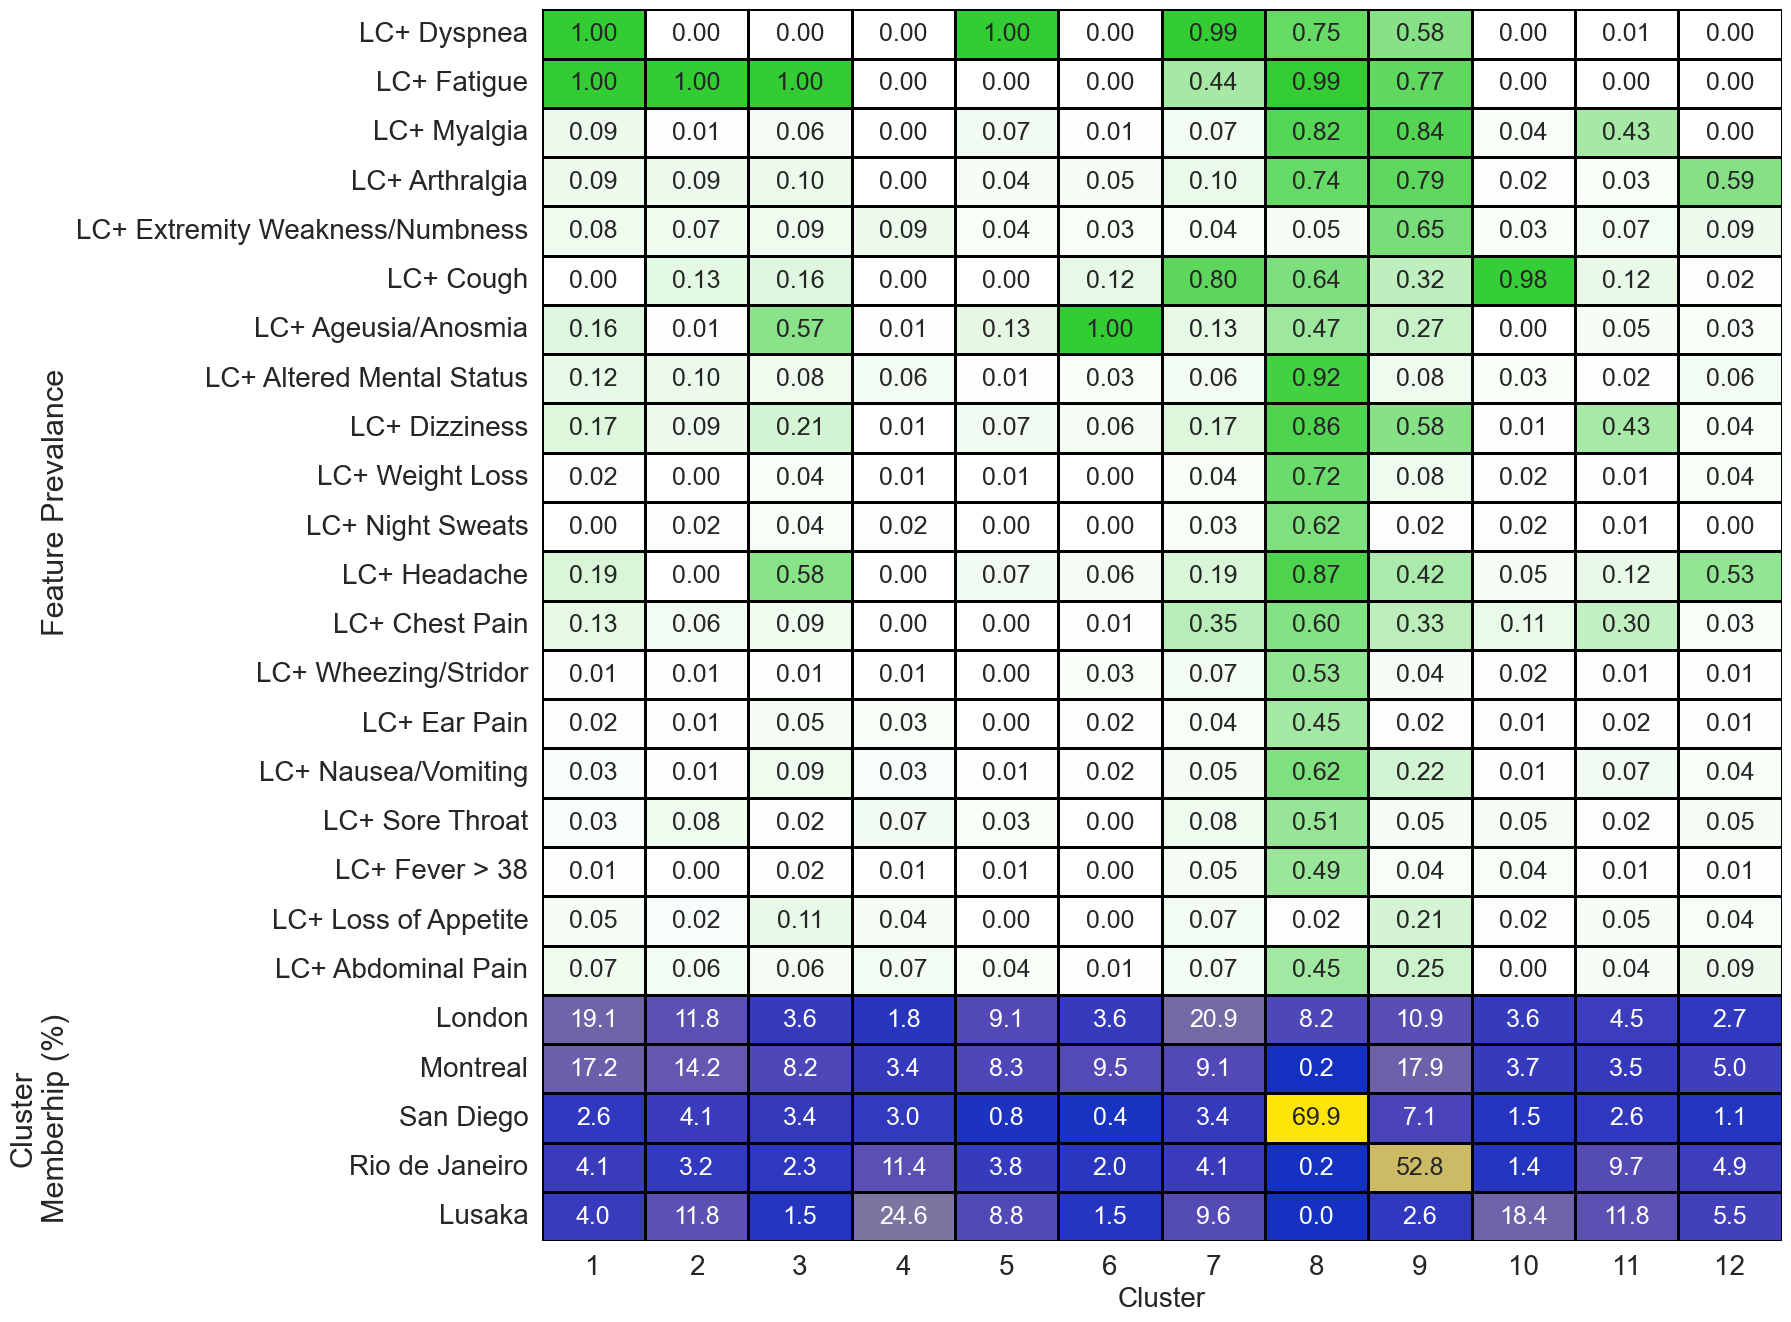

In [566]:
# heatmap of features by cluster
M = X.copy()
M = M[important_features]
M["cluster"] = [c+1 for c in cluster_labels]

# get the means
mfv = M.groupby("cluster").mean()

# sort the index by the order in fi_df
mfv = mfv[fi_df["Feature"]]

# transpose
mfv = mfv.T

# rename mfv index
mfv.index = mfv.index.map(feature_map)


fig, (axs0, axs1) = plt.subplots(2, 1, figsize=(16,16),  sharex = True, height_ratios=[8,2])
fig.subplots_adjust(hspace = 0.0)

# logscale the heatmap colour
# cmap = sns.color_palette("viridis", as_cmap = True)

from matplotlib.colors import LogNorm

sns.heatmap(mfv[:20], 
            cmap = cmap, 
            # norm = LogNorm(),
            ax = axs0, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".2f",
                annot_kws = {"fontsize": 18}
)

# turn off the xticks and x label
axs0.set_xticks([]); axs0.set_xlabel("")

sns.heatmap(cbsm,
            # cmap = 'viridis', 
            cmap = cc.cm.bjy, 
            # norm = LogNorm(),
            ax = axs1, 
            cbar = False, 
            vmin = 0, 
            linewidth = 1, 
            # linewidth = 0.5, 
            square = False, 
            linecolor = 'k',
              annot = True,
                fmt = ".1f",
                annot_kws = {"fontsize": 18}
)
axs0.set_ylabel("Feature Prevalance", fontsize = FONTSIZE-2)
axs1.set_ylabel("Cluster\nMemberhip (%)", fontsize = FONTSIZE-2)
# rotate axs1 yticks 90 degrees
axs1.set_yticklabels(axs1.get_yticklabels(), rotation = 00)

# make x axis label alrger
axs1.set_xlabel("Cluster", fontsize = FONTSIZE-4)
#make tick labels larger
axs1.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
axs0.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# fig.align_xlabels()

# align the ylabels
fig.align_ylabels()

# output the figure
plt.savefig(f"{figdir}/SYMPT_2-only-feature-prevalence-by-cluster-600.png", dpi = 600, bbox_inches = 'tight')
plt.savefig(f"{figdir}/SYMPT_2-only-feature-prevalence-by-cluster-300.png", dpi = 300, bbox_inches = 'tight')


In [567]:
# # read in a table of weights per symptom per site from JSON directory

# # read in the json file
# with open(f"./JSON/EXPERIMENTAL-missing-symptoms.json", "r") as f:
#     symptom_weights = json.load(f)

# sw_df = pd.DataFrame(symptom_weights)

# # sort the columns by the order in site_name_dict
# sw_df = sw_df[site_name_dict.values()]

# sw_df
# # for each cluster, get the fraction of recrods per site

# c2 = plot_df.groupby("Cluster")["Site"].value_counts(normalize = True).unstack().T.fillna(0)

# # sort the index by the order in site_name_dict
# c2 = c2.loc[site_name_dict.values()]
# c2
# # sum the symptoms by site and rename the index
# symptoms_by_site = LC_pos_.groupby("SITE")[lc_symptoms].sum().rename(index = site_name_dict)
# symptoms_by_site * sw_df.T
# # get the dot product of the symptoms_by_site and c2
# symptoms_by_cluster = np.array(symptoms_by_site.T).dot(np.array(c2))
# symptoms_by_cluster
# # convert to a df
# sbc_df = pd.DataFrame(symptoms_by_cluster)
# sbc_df.index = symptoms_by_site.columns
# sbc_df.columns = [c+1 for c in sbc_df.columns]
# sbc_df

# # sort sbc_df by the order in fi_df
# sbc_df = sbc_df.loc[fi_df["Feature"]]
# sbc_df

# # scale to be in the range 0-1
# sbc_df = sbc_df/sbc_df.max().max()
# sbc_df
# sns.heatmap(sbc_df, cmap = cmap, annot = True, fmt = ".2f", annot_kws = {"fontsize": 8})
# sns.heatmap(mfv, cmap = cmap, annot = True, fmt = ".2f", annot_kws = {"fontsize": 8})


In [568]:
cbs

cluster          1    2   3   4   5   6   7    8    9   10  11  12
Site                                                              
London           21   13   4   2  10   4  23    9   12   4   5   3
Montreal        154  127  73  30  74  85  81    2  160  33  31  45
San Diego         7   11   9   8   2   1   9  186   19   4   7   3
Rio de Janeiro   27   21  15  74  25  13  27    1  344   9  63  32
Lusaka           11   32   4  67  24   4  26    0    7  50  32  15

In [569]:
# summarize cbs by total number of records per cluster
cbs2 = cbs.sum(axis = 0)/cbs.sum().sum()*100

cbs2 = pd.DataFrame(cbs2, columns = ["Fraction"])

# reset the index
cbs2.reset_index(inplace = True)


In [570]:
# add a column with the symptoms



cbs2["s1"] = pd.Series(["Dyspnea", "Fatigue", "Fatigue", "Sore Throad",
              "Dyspnea", "Aguesia/Anosmia", "Dyspnea", "Fatigue",
              "Myalgia", "Cough", "Mylalgia", "Arthralgia"])

cbs2["s2"] = pd.Series(["Fatigue", "", "Headache", "Abdo Pain",
              "", "", "Cough", "Headache",
              "Arthralgia","", 'Dizziness', "Headache"])
cbs2["s3"] = pd.Series(["", "", "Aguesia/Anosmia", "Others (diffuse)",
              "", "", "Chest Pain", "Others (diffuse)",
              "Others (diffuse)","", 'Chest Pain', ""])

In [571]:
cbs2

cluster   Fraction               s1          s2                s3
0         1  10.027347          Dyspnea     Fatigue                  
1         2   9.298086          Fatigue                              
2         3   4.785779          Fatigue    Headache   Aguesia/Anosmia
3         4   8.249772      Sore Throad   Abdo Pain  Others (diffuse)
4         5   6.153145          Dyspnea                              
5         6   4.876937  Aguesia/Anosmia                              
6         7   7.566089          Dyspnea       Cough        Chest Pain
7         8   9.024613          Fatigue    Headache  Others (diffuse)
8         9  24.703737          Myalgia  Arthralgia  Others (diffuse)
9        10   4.557885            Cough                              
10       11   6.289881         Mylalgia   Dizziness        Chest Pain
11       12   4.466727       Arthralgia    Headache

In [572]:
# add a column to cbs2 that counts the number of symptoms
cbs2["n"] = cbs2["s1"].apply(lambda x: 1 if x != "" else 0) + cbs2["s2"].apply(lambda x: 1 if x != "" else 0) + cbs2["s3"].apply(lambda x: 1 if x != "" else 0)

In [573]:
cbs2

cluster   Fraction               s1          s2                s3  n
0         1  10.027347          Dyspnea     Fatigue                    2
1         2   9.298086          Fatigue                                1
2         3   4.785779          Fatigue    Headache   Aguesia/Anosmia  3
3         4   8.249772      Sore Throad   Abdo Pain  Others (diffuse)  3
4         5   6.153145          Dyspnea                                1
5         6   4.876937  Aguesia/Anosmia                                1
6         7   7.566089          Dyspnea       Cough        Chest Pain  3
7         8   9.024613          Fatigue    Headache  Others (diffuse)  3
8         9  24.703737          Myalgia  Arthralgia  Others (diffuse)  3
9        10   4.557885            Cough                                1
10       11   6.289881         Mylalgia   Dizziness        Chest Pain  3
11       12   4.466727       Arthralgia    Headache                    2

In [574]:
cbs2["colour"] = [cc.glasbey_hv[i] for i in cbs2["n"]]

# change the value of colour if s3 contains diffuse
idx = cbs2.loc[cbs2["s3"] == "Others (diffuse)"] 

cbs2.loc[idx.index, "colour"] = "#dedbef"

In [575]:
for i, row in cbs2.iterrows():
    print(i, row["Fraction"], row["s1"], row["s2"], row["s3"], row["colour"])

    cbs2.loc[i, "label"] = f"Cluster {row['cluster']}\n{row['Fraction']:0.1f}%\n{row['s1']}\n{row['s2']}\n{row['s3']}"



0 10.027347310847768 Dyspnea Fatigue  [0.898039, 0.682353, 0.219608]
1 9.298085688240656 Fatigue   [0.988235, 0.309804, 0.188235]
2 4.785779398359161 Fatigue Headache Aguesia/Anosmia [0.427451, 0.564706, 0.309804]
3 8.249772105742935 Sore Throad Abdo Pain Others (diffuse) #dedbef
4 6.153144940747493 Dyspnea   [0.988235, 0.309804, 0.188235]
5 4.8769371011850495 Aguesia/Anosmia   [0.988235, 0.309804, 0.188235]
6 7.566089334548769 Dyspnea Cough Chest Pain [0.427451, 0.564706, 0.309804]
7 9.02461257976299 Fatigue Headache Others (diffuse) #dedbef
8 24.703737465815863 Myalgia Arthralgia Others (diffuse) #dedbef
9 4.557885141294439 Cough   [0.988235, 0.309804, 0.188235]
10 6.289881494986327 Mylalgia Dizziness Chest Pain [0.427451, 0.564706, 0.309804]
11 4.466727438468551 Arthralgia Headache  [0.898039, 0.682353, 0.219608]


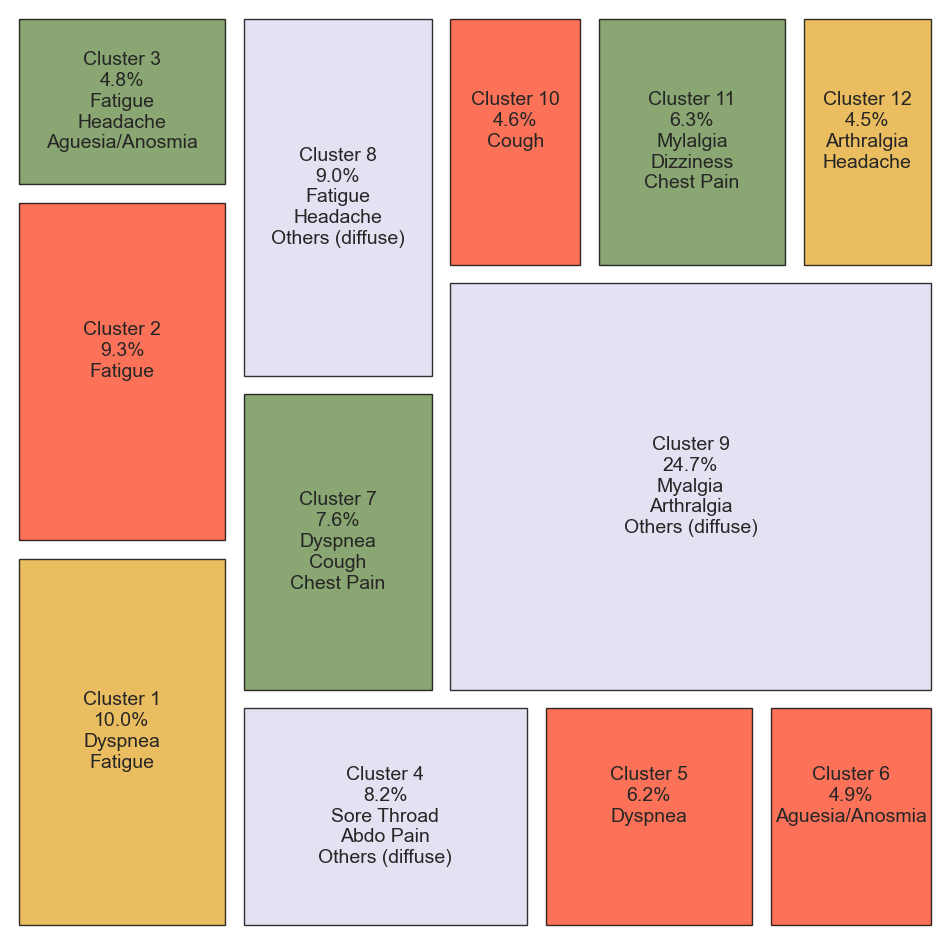

In [576]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))


squarify.plot(sizes = cbs2["Fraction"], label = cbs2["label"], alpha = 0.8, color = cbs2["colour"], edgecolor = "black", pad = True, ax = ax, text_kwargs = {"fontsize": 14})
plt.axis('off')

plt.savefig(f"{figdir}/SYMPT_2-only-symptoms-TREEMAP-300.png", dpi = 300, bbox_inches = 'tight')
plt.savefig(f"{figdir}/SYMPT_2-only-symptoms-TREEMAP-600.png", dpi = 600, bbox_inches = 'tight')

In [ ]:
# # for each cluster, find the top 2 fieature names in mfv
# mfv2 = mfv.copy()

# # get the top 2 features per cluster
# mfv2 = mfv2.apply(lambda x: x.nlargest(2).index)

# # rename the index
# # mfv2.index = mfv2.index.map(cluster_name_dict)

# mfv2.T

In [ ]:
# join mfv2.T with cbs2
mfv3 = mfv2.T.join(cbs2, how = "inner")
mfv3

0                                1  \
cluster                                                                     
1                            LC+ Dyspnea                      LC+ Fatigue   
2                            LC+ Dyspnea              LC+ Ageusia/Anosmia   
3                            LC+ Fatigue                        LC+ Cough   
4                            LC+ Fatigue                     LC+ Headache   
5                            LC+ Fatigue        LC+ Altered Mental Status   
6                    LC+ Ageusia/Anosmia                        LC+ Cough   
7        LC+ Extremity Weakness/Numbness                  LC+ Sore Throat   
8                            LC+ Dyspnea                        LC+ Cough   
9                            LC+ Fatigue                      LC+ Dyspnea   
10                             LC+ Cough                   LC+ Chest Pain   
11                          LC+ Headache                   LC+ Arthralgia   
12                           LC+ Myalgia                    LC+ Dizziness   
13                           LC+ Fatigue  LC+ Extremity Weakness/Numbness   
14                           LC+ Myalgia                   LC+ Arthralgia   

         Patient Membership (%)  
cluster                          
1                     10.255242  
2                      6.244303  
3                      9.298086  
4                      6.381039  
5                      8.614403  
6                      5.150410  
7                      8.295351  
8                      4.102097  
9                      3.463993  
10                     4.421149  
11                     6.426618  
12                     4.284412  
13                    16.089335  
14                     6.973564

In [ ]:
the_col = [cc.glasbey_hv[i] for i in cbs2.index]

mfv3["labels"] = [f"{c}\n{p:.1f}%\n{a1}\n{a2}" for c,p,a1,a2 in zip(mfv3.index, mfv3["Patient Membership (%)"], mfv3[0], mfv3[1])]

In [ ]:
import squarify

(0.0, 100.0, 0.0, 100.0)

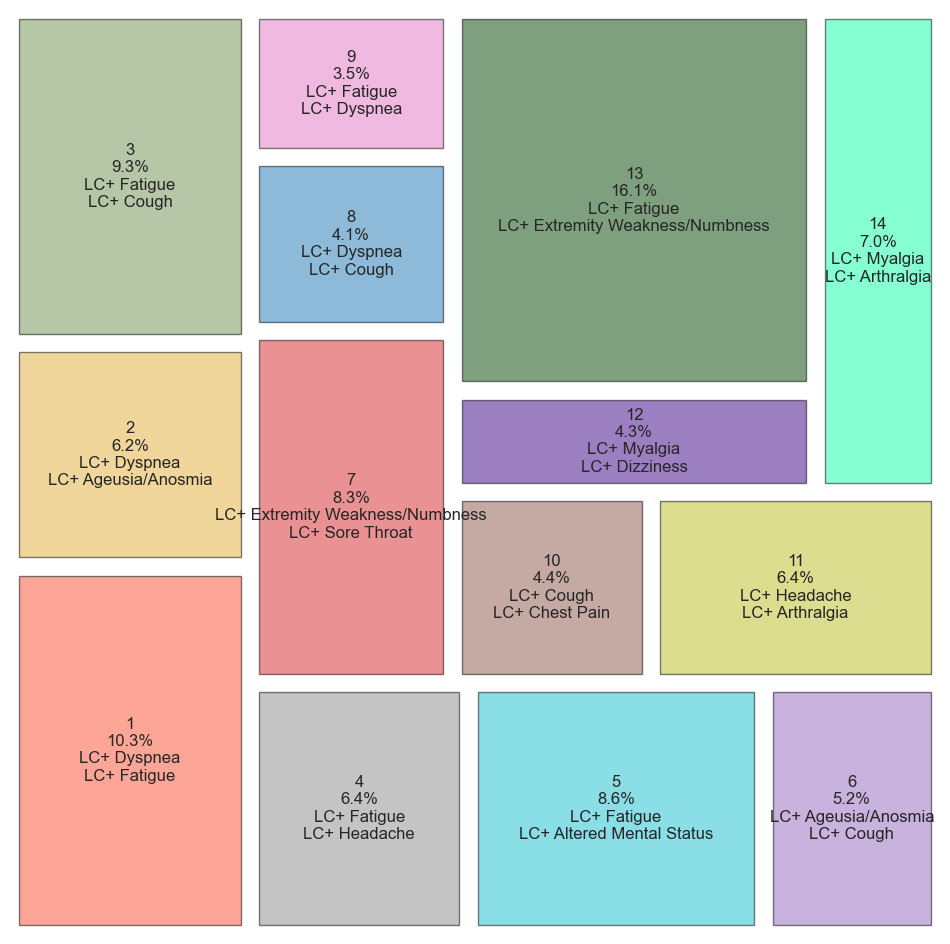

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))


squarify.plot(sizes = mfv3["Patient Membership (%)"], label = mfv3["labels"], alpha = 0.5, color = the_col, edgecolor = "black", pad = True, ax = ax)
plt.axis('off')